# Covid-19 Prediction Using DCNN Transfer Learning

A Transfer Learning DCNN Method for Classifying COVID-19 Patients Using Chest X-Ray Images

# First Things First

## Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torchsummary import summary
from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        classification_report, 
        confusion_matrix,
        precision_recall_curve,
        average_precision_score,
        ConfusionMatrixDisplay,
        PrecisionRecallDisplay,
      )
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from datetime import datetime
from pathlib import Path
import random
import sys, os
import shutil
from glob import glob
import imageio
import json

## Configaration

### Fill Up The Form First

In [ ]:
#@title ## Configuration Form

#@markdown ---
#@markdown #### **Developer Attention**
#@markdown **Development Stage**:
#@markdown Set it `False` during production or final stage.
#@markdown When it set to `True`, this will train on less data 
#@markdown to reduce training time in development stage.
_is_development_stage = False #@param {type:"boolean"}

#@markdown **Active Initial Training Stage**:
#@markdown When it is `True`, then `Initial Training` will be happen.
#@markdown It sould be active at the first time training, later only  
#@markdown `Resume Training` should be active for repeatative training epochs.
_is_active_initial_training_stage = False #@param {type:"boolean"}
#@markdown ---
#@markdown **Resume Training**:
#@markdown When it is `True`, then `Resume Training` will be happen.
_is_resume_training_stage = False #@param {type:"boolean"}
#@markdown ---
#@markdown **Evaluation Active**:
#@markdown When it is `True`, then `Evaluation` will be happen.
_is_active_evaluation_stage = False #@param {type:"boolean"}
#@markdown ---
#@markdown **Google Drive Related**:
#@markdown Using google drive is suitable than local machine
#@markdown because it takes less time to move arround files.
_save_models_to_google_drive = False #@param {type:"boolean"}
_load_models_from_google_drive = False #@param {type:"boolean"}
_save_logs_to_google_drive = False #@param {type:"boolean"}
_use_dataset_from_google_drive = False #@param {type:"boolean"}
_use_dataset_file_names_from_google_drive = True #@param {type:"boolean"}
_save_colab_dataset_to_google_drive = False #@param {type:"boolean"}
#@markdown **Google Drive Path**:
#@markdown Give a valid `Path` by selecting or editing.
#@markdown Make sure path exist on google drive.
_google_drive_models_path = 'MyDrive/ML/covid19v2/models' #@param ["MyDrive/ML/concrete-crack-detection/models", "MyDrive/academic/research/concrete-crack-detection/models"] {allow-input: true}
_google_drive_logs_path = 'MyDrive/ML/covid19v2/logs' #@param ["MyDrive/ML/concrete-crack-detection/logs", "MyDrive/academic/research/concrete-crack-detection/logs"] {allow-input: true}
_google_drive_dataset_path = 'MyDrive/ML/covid19v2/data' #@param ["MyDrive/ML/concrete-crack-detection/data", "MyDrive/academic/research/concrete-crack-detection/data"] {allow-input: true}
_google_drive_dataset_file_names_json_file_path = 'MyDrive/ML/covid19v2/data/dataset_dict.json' #@param ["MyDrive/ML/concrete-crack-detection/data/file-names", "MyDrive/academic/research/concrete-crack-detection/data/dataset_dict.json"] {allow-input: true}
#@markdown ---

#@markdown **Local Computer Related**:
#@markdown Using local computer is not easy as google drive,
#@markdown because it takes more time to move arround files.
_download_saved_models_to_local_machine = False #@param {type:"boolean"}
_upload_saved_models_from_local_machine = False #@param {type:"boolean"}
#@markdown ---

#@markdown #### **Number of Training Epochs**
#@markdown Initial trainig epochs only be used first time model train.
#@markdown Then the initial trained models checkpoint will be saved for
#@markdown later training starting from last epochs (Resume Training).
_initial_trainig_epochs =  1 #@param {type:"slider", min:1, max:100, step:1}

#@markdown Resume trainig epochs will be used to train resume trainig from
#@markdown the previous trained models checkpoint, and after finishing this
#@markdown training it will save current models checkpoint 
#@markdown again for later Resume Training.
_resume_trainig_epochs = 1 #@param {type:"slider", min:1, max:100, step:1}
#@markdown ---
#@markdown #### **Batch Size**
#@markdown It will be used during load data and training.
#@markdown If there found memory limitation try to reduce it.
_batch_size = 128 #@param [128, 64, 32, 16]
#@markdown ---
#@markdown #### **Clear Google Colab** content directory
#@markdown If it is `True` some files will be removed from colab
#@markdown which are generated previous times. Example: logs, data, models etc
_clean_colab_unwanted_files = False #@param {type:"boolean"}
#@markdown ---
#@markdown #### **Kaggle API**
#@markdown If it is `True` credentials file from kaggle api required named `kaggle.json`
_use_kaggle_api = True #@param {type:"boolean"}
_use_kaggle_cred_from_drive = True #@param {type:"boolean"}
_google_drive_kaggle_cred_file_path = "MyDrive/ML/credentials/kaggle/kaggle.json" #@param ["MyDrive/ML/credentials/kaggle/kaggle.json"] {allow-input: true}
#@markdown ---

### Validate Form and Set Up Configurations

In [ ]:
# This is for reducing train and test time during code testing or development stage
# Make it False in finela stage
DEVELOPMENT_STAGE = _is_development_stage

# It sould be active at the first time training, later only  
# `Resume Training` should be active for repeatative training epochs.
ACTIVE_INITIAL_TRAINING_STAGE = _is_active_initial_training_stage

# If its True then Resume Training will be happen.
RESUME_TRAINING_STAGE = _is_resume_training_stage

# If this is True, it will evaluate models and create history logs
ACTIVE_EVALUATION_STAGE = _is_active_evaluation_stage

# Google Drive path
SAVE_MODELS_TO_GOOGLE_DRIVE = _save_models_to_google_drive
GOOGLE_DRIVE_MODELS_PATH = _google_drive_models_path
LOAD_MODELS_FROM_GOOGLE_DRIVE = _load_models_from_google_drive
SAVE_LOGS_TO_GOOGLE_DRIVE = _save_logs_to_google_drive
GOOGLE_DRIVE_LOGS_PATH = _google_drive_logs_path
LOAD_DATASET_FROM_GOOGLE_DRIVE = _use_dataset_from_google_drive
GOOGLE_DRIVE_DATASET_PATH = _google_drive_dataset_path
SAVE_COLAB_DATASET_TO_GOOGLE_DRIVE = _save_colab_dataset_to_google_drive
USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE = _use_dataset_file_names_from_google_drive
GOOGLE_DRIVE_DATASET_FILE_NAMES_PATH = _google_drive_dataset_file_names_json_file_path

# Kaggle API
USE_KAGGLE_API = _use_kaggle_api
USE_KAGGLE_CRED_FILE_FROM_GOOGLE_DRIVE = _use_kaggle_cred_from_drive
GOOGLE_DRIVE_KAGGLE_CRED_FILE_PATH = _google_drive_kaggle_cred_file_path

# Download Saved Models to Local Machine
DOWNLOAD_SAVED_MODELS_LOCALY = _download_saved_models_to_local_machine

# Load Saved Models from Local Machine
LOAD_MODELS_FROM_LOCAL = _upload_saved_models_from_local_machine

# Trainig and Validation EPOCHS
INITIAL_TRAINING_EPOCHS = _initial_trainig_epochs
RESUME_TRAINING_EPOCHS = _resume_trainig_epochs

# Batch Size
BATCH_SIZE = _batch_size

# Dataset Directory Name
DATASET_DIRNAME = 'data'

# This is the root directory of dataset
# this path can be changed 
# i.e when using mounted google drive dataset this path will be updated
DATASET_PATH = Path('data')

# Logs Directory Name
LOGS_DIRNAME = 'logs'

# Models Directory Name in Colab
MODELS_DIRNAME_COLAB = 'models'

# Clear Colab by removing previous files/folder
CLEAN_COLAB = _clean_colab_unwanted_files

## Mount Google Drive (If Required) and Validate Config

In [ ]:
# Google Drive Mount Directory Name
GOOGLE_DRIVE_MOUNTED_DIRNAME = 'gdrive'

In [ ]:
# If there need to access Google Drive Mount at Google Drive
if SAVE_MODELS_TO_GOOGLE_DRIVE or \
  LOAD_MODELS_FROM_GOOGLE_DRIVE or \
  SAVE_LOGS_TO_GOOGLE_DRIVE or \
  LOAD_DATASET_FROM_GOOGLE_DRIVE or\
  USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE or \
  USE_KAGGLE_CRED_FILE_FROM_GOOGLE_DRIVE:
  from google.colab import drive
  drive.mount(GOOGLE_DRIVE_MOUNTED_DIRNAME)

Mounted at gdrive


In [ ]:
# Now Validate Some User Given Drive Path
if SAVE_MODELS_TO_GOOGLE_DRIVE or LOAD_MODELS_FROM_GOOGLE_DRIVE:
  _gdrive_path = Path(GOOGLE_DRIVE_MOUNTED_DIRNAME)/ GOOGLE_DRIVE_MODELS_PATH
  if not os.path.exists(_gdrive_path):
    raise Exception(f"Google Drive Path '{_gdrive_path}' does not exist")
if SAVE_LOGS_TO_GOOGLE_DRIVE:
  _gdrive_path = Path(GOOGLE_DRIVE_MOUNTED_DIRNAME)/ GOOGLE_DRIVE_LOGS_PATH
  if not os.path.exists(_gdrive_path):
    raise Exception(f"Google Drive Path '{_gdrive_path}' does not exist")
if LOAD_DATASET_FROM_GOOGLE_DRIVE:
  _gdrive_path = Path(GOOGLE_DRIVE_MOUNTED_DIRNAME)/ GOOGLE_DRIVE_DATASET_PATH
  if not os.path.exists(_gdrive_path):
    raise Exception(f"Google Drive Path '{_gdrive_path}' does not exist")
  
  # Update DATASET_PATH path so that data use from mounted gdrive
  DATASET_PATH = Path(GOOGLE_DRIVE_MOUNTED_DIRNAME)/ f"{GOOGLE_DRIVE_DATASET_PATH}"

# if USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE is True then 
if USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE:
  _gdrive_path = Path(GOOGLE_DRIVE_MOUNTED_DIRNAME)/ GOOGLE_DRIVE_DATASET_FILE_NAMES_PATH
  if not os.path.exists(_gdrive_path):
    raise Exception(f"Google Drive Path '{_gdrive_path}' does not exist")
  
  # use only one dataset
  # so set false to LOAD_DATASET_FROM_GOOGLE_DRIVE
  if LOAD_DATASET_FROM_GOOGLE_DRIVE:
    LOAD_DATASET_FROM_GOOGLE_DRIVE = False
    DATASET_PATH = DATASET_DIRNAME


# Kaggle
if USE_KAGGLE_API and USE_KAGGLE_CRED_FILE_FROM_GOOGLE_DRIVE:
  _gdrive_path = Path(GOOGLE_DRIVE_MOUNTED_DIRNAME)/ GOOGLE_DRIVE_KAGGLE_CRED_FILE_PATH
  if not os.path.exists(_gdrive_path):
    raise Exception(f"Google Drive Path '{_gdrive_path}' does not exist")
  
  if not (GOOGLE_DRIVE_KAGGLE_CRED_FILE_PATH.split('/')[-1] == 'kaggle.json'):
    raise Exception(f"File 'kaggle.json' does not exist at '{_gdrive_path}'")


## Kaggle API

In [ ]:
# Kaggle
if USE_KAGGLE_API:
  _root_kaggle_dir = "/root/.kaggle"
  if USE_KAGGLE_CRED_FILE_FROM_GOOGLE_DRIVE:
    if not os.path.exists(_root_kaggle_dir):
      print(f"{_root_kaggle_dir} does not exists. Trying to create.")
      try:
        os.makedirs(_root_kaggle_dir, exist_ok=True)
        print(f"Path: {_root_kaggle_dir} created.")
      except Exception as e:
        print(f"Path cration: {_root_kaggle_dir} failed.")
        raise e
      
      # copy kaggle.json to '~/.kaggle/'
      try:
        os.system(f"cp {Path(GOOGLE_DRIVE_MOUNTED_DIRNAME)/ GOOGLE_DRIVE_KAGGLE_CRED_FILE_PATH} {_root_kaggle_dir}")
        print(f"kaggle.json copied to {_root_kaggle_dir}")
        print(f"List inside {_root_kaggle_dir}:", *os.listdir(_root_kaggle_dir), sep='\n')
      except Exception as e:
        print(f"kaggle.json copy failed to {_root_kaggle_dir}")
        print(f"List inside {_root_kaggle_dir}:", *os.listdir(_root_kaggle_dir), sep='\n')
        raise e
  else:
    # if file does not exist in that '~/.kagle' directory
    # request for upload a kaggle.json file
    if not os.path.exists(f'{_root_kaggle_dir}/kaggle.json'):
      from google.colab import files
      print("Please Upload Kaggle API credential 'kaggle.json' file:")
      uploaded_kaggle_cred_file = files.upload()

      if not os.path.exists(_root_kaggle_dir):
        print(f"{_root_kaggle_dir} does not exists. Trying to create.")
        try:
          os.makedirs(_root_kaggle_dir, exist_ok=True)
          print(f"Path: {_root_kaggle_dir} created.")
        except Exception as e:
          print(f"Path cration: {_root_kaggle_dir} failed.")
          raise e

      # now move the kaggle.json file to  '~/.kagle' directory
      try:
        os.system(f"cp kaggle.json {_root_kaggle_dir}")
      except Exception as e:
        raise e
  # finaly change the chmod of the kaggle.json file
  try:
    os.system(f"chmod 600 {_root_kaggle_dir}/kaggle.json")
  except Exception as e:
    raise e
  
  print(f"List inside {_root_kaggle_dir}:", *os.listdir(f"{_root_kaggle_dir}"), sep='\n')

/root/.kaggle does not exists. Trying to create.
Path: /root/.kaggle created.
kaggle.json copied to /root/.kaggle
List inside /root/.kaggle:
kaggle.json
List inside /root/.kaggle:
kaggle.json


In [ ]:
# now try to import kaggle
try:
    import kaggle
except Exception as e:
  print(f"Exception: {e}")
  print("Tring to install kaggle")
  os.system(f"pip -q install kaggle")
  try:
    import kaggle
  except Exception as e:
    raise e
print("kaggle imported")

kaggle imported


## Device (CPU, GPU, TPU)

In [ ]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Useful Functions

In [ ]:
# It will print tree of a directory with optional files path
def tree_printer(root, show_files=False):
  for root, dirs, files in os.walk(root):
    for d in dirs:
      print(os.path.join(root, d))
    if show_files:
      for f in files:
        print(os.path.join(root, f))

In [ ]:
# A utility function for copying files and directory
def copytree(src, dst, symlinks = False, ignore = None):
  """
  - Same behavior as shutil.copytree, with symlinks and ignore parameters
  - Create directory destination structure if non existant
  - Will not fail if dst already exists
  Details: https://stackoverflow.com/a/22331852/8520849
  """
  if not os.path.exists(dst):
    os.makedirs(dst)
    shutil.copystat(src, dst)
  lst = os.listdir(src)
  if ignore:
    excl = ignore(src, lst)
    lst = [x for x in lst if x not in excl]
  for item in lst:
    s = os.path.join(src, item)
    d = os.path.join(dst, item)
    if symlinks and os.path.islink(s):
      if os.path.lexists(d):
        os.remove(d)
      os.symlink(os.readlink(s), d)
      try:
        st = os.lstat(s)
        mode = stat.S_IMODE(st.st_mode)
        os.lchmod(d, mode)
      except:
        pass # lchmod not available
    elif os.path.isdir(s):
      copytree(s, d, symlinks, ignore)
    else:
      shutil.copy2(s, d)

In [ ]:
def generate_file_name(*args, extension=None, sep='-', add_date=True):
  args = [str(item) for item in args]
  name = f'{sep}'.join(args)
  if add_date:
    from datetime import datetime
    str_f_time = '%m_%d_%Y_%H_%M_%S' if not (sep=='_') else '%m-%d-%Y-%H-%M-%S'
    name = name + f"{sep if name else ''}{datetime.now().strftime(str_f_time)}"
  if extension:
    name = name + extension if extension[0] == '.' else name + '.' + extension
  return name

# print(generate_file_name(*list(range(10)), extension='d', sep='_', add_date=True))

# Dounload and Prepare Dataset

In [ ]:
# dataset classes and labels
CLASSES = {
    # '<class label name>': ('<dataset class dirname>', '<class title label>', <Y Label>)
    'covid': ('COVID', 'COVID', 0),
    'lung_opacity': ('Lung_Opacity', 'Lung Opacity', 1),
    'normal': ('Normal', 'Normal', 2),
    # 'viral_pneumonia': ('Viral Pneumonia', 'Viral Pneumonia', 3),
}

SPLIT_SET = {
    # '<set label>': ('<set dirname>', '<set title>')
    'train': ('train', 'Train'),
    'test': ('test', 'Test'),
    'val': ('val', 'Validation'),
}

SPLIT_RATIO = {
    # '<set label>': <parcentage over whole dataset>
    'train': 0.70,
    'test': 0.20,
    'val': 0.10,
}
# at least this number of file exist in every class
SAFE_MAX = 3616 # 1345

BALANCED_NUMERS = {
    # '<class label name>': (<number of files exists>, <number of files for dataset>)
    'covid': (3616, SAFE_MAX+10 if SAFE_MAX+10 <= 3616 else SAFE_MAX),
    'lung_opacity': (6012, SAFE_MAX+20 if SAFE_MAX+20 <= 6012 else SAFE_MAX),
    'normal': (10000, SAFE_MAX+30 if SAFE_MAX+30 <= 10000 else SAFE_MAX),
    # 'viral_pneumonia': (1345, SAFE_MAX+5 if SAFE_MAX+5 <= 1345 else SAFE_MAX),
}
RAW_DATASET_DIRNAME = "COVID-19_Radiography_Dataset"

# set the number of classes
K = len(CLASSES)

## Kaggle Dataset

In [ ]:
# ! kaggle datasets download <name-of-dataset>
# ! kaggle datasets download tawsifurrahman/covid19-radiography-database
if USE_KAGGLE_API:
  _kaggle_dataset_name = 'tawsifurrahman/covid19-radiography-database'
  try:
    os.system(f"kaggle datasets download {_kaggle_dataset_name}")
  except Exception as e:
    raise e
  
  print(*os.listdir('.'), sep='\n')


.config
gdrive
covid19-radiography-database.zip
sample_data


## Dataset Utils

In [ ]:
def unzip_dataset(ziped_dataset_path="covid19-radiography-database.zip"):
  unziped_dataset_dirname = "COVID-19_Radiography_Dataset"
  # remove DATASET_DIRNAME dir if already there and recreate it
  try:
    os.system(f"rm -r {unziped_dataset_dirname}")
  except Exception as e:
    pass
  # os.makedirs('data', exist_ok=True)

  if os.path.exists(ziped_dataset_path):
    try:
      print(f"Unizipping '{ziped_dataset_path}' dataset")
      os.system(f"unzip -qq -o {ziped_dataset_path}")
    except Exception as e:
      print(f"Failed: Unizipping '{ziped_dataset_path}' dataset")
      raise e
  else:
    print(f"Dataset zip file '{ziped_dataset_path}' not found!")
  
  print(f"List inside {unziped_dataset_dirname}:", *os.listdir(unziped_dataset_dirname), sep='\n')


# generate dataset according to ratio and criterion by moving files from src_dir
def generate_dataset(src_dir, dst_dir, CLASSES=CLASSES, SPLIT_SET=SPLIT_SET, 
                     SPLIT_RATIO=SPLIT_RATIO, BALANCED_NUMERS=BALANCED_NUMERS,
                     LOAD_FROM_DASET_DICT=False, DATASET_DICT=None, 
                     clear_dst_dir=False,
                     unzip_src_dataset=True,
                     remove_src_dir=True):
  """
  Generate dataset according to ratio and criterion by moving files from src_dir
  """
  if not os.path.exists(src_dir):
    if unzip_src_dataset:
      print("Unizipping Dataset...")
      unzip_dataset()
      print("Unizipping completed.")
    if not os.path.exists(src_dir):
      raise Exception(f"src_dir: '{src_dir}' invalid!")
  else:
    if unzip_src_dataset:
      print("Unizipping Dataset...")
      unzip_dataset()
      print("Unizipping completed.")
    if not os.path.exists(src_dir):
      raise Exception(f"src_dir: '{src_dir}' invalid!")
  
  if not os.path.exists(dst_dir):
    # try to create this dst_dir
    try:
      os.makedirs(Path(dst_dir), exist_ok=True)
    except Exception as e:
      print(f"dst_dir: '{dst_dir}' invalid!")
      raise e
  elif clear_dst_dir:
    # try to clear and re-create the dst_dir
    try:
      os.system(f"rm -r {Path(dst_dir)}")
      os.makedirs(Path(dst_dir), exist_ok=True)
    except Exception as e:
      print(f"dst_dir: '{dst_dir}' invalid!")
      raise e


  # make dst tree
  for split_set_name in SPLIT_SET.keys():
    try:
      os.makedirs(Path(dst_dir)/split_set_name, exist_ok=True)
      for klass_dir_name in CLASSES.keys():
        try:
          os.makedirs(Path(dst_dir)/split_set_name/klass_dir_name, exist_ok=True)
        except OSError as e:
          raise e
    except OSError as e:
      raise e

  if LOAD_FROM_DASET_DICT and isinstance(DATASET_DICT, dict):
    for split_set_name in SPLIT_SET.keys():
      curr_set_cnt = 0
      for klass_key, (src_klass_dir_name, _, _) in CLASSES.items():
        for f in DATASET_DICT[split_set_name][klass_key]:
          try:
            shutil.move(str(Path(src_dir)/src_klass_dir_name/f), 
                          str(Path(dst_dir)/split_set_name/klass_key))
            curr_set_cnt += 1
          except Exception as e:
            raise e
        
        print(f"Moved {len(list(os.listdir(Path(dst_dir)/split_set_name/klass_key)))} \
        (target {len(DATASET_DICT[split_set_name][klass_key])}) \
        files at '{Path(dst_dir)/split_set_name/klass_key}', \
        from '{Path(src_dir)/src_klass_dir_name}'.")
    
      # print split set summary
      print(f"Total ({split_set_name} set): {curr_set_cnt}")

    # remove src_dir
    if remove_src_dir:
      try:
        os.system(f"rm -r {src_dir}")
      except Exception as e:
        pass
    
    return
  
  # generate summary of files
  dataset_dict = {}

  # move files according to ration and classes
  for split_set_name, ratio in SPLIT_RATIO.items():
    dataset_dict[split_set_name] = {k:[] for k in CLASSES.keys()}
    curr_set_cnt = 0
    for klass_key, (src_klass_dir_name, _, _) in CLASSES.items():
      src_files = list(os.listdir(Path(src_dir)/src_klass_dir_name))
      src_n = len(src_files)
      target_n = int(BALANCED_NUMERS[klass_key][1] * ratio)
      
      counter = 0
      for f in src_files:
        if counter <= target_n and random.random() <= ratio:
          try:
            shutil.move(str(Path(src_dir)/src_klass_dir_name/f), 
                        str(Path(dst_dir)/split_set_name/klass_key))
            counter += 1
            curr_set_cnt += 1
          except Exception as e:
            raise e
      
      src_files = list(os.listdir(Path(src_dir)/src_klass_dir_name))
      src_n = len(src_files)
      if (src_n >= (target_n - counter)) and ((target_n - counter) > 0):
        random.shuffle(src_files)
        for f in src_files[:(target_n - counter)]:
          try:
            shutil.move(str(Path(src_dir)/src_klass_dir_name/f), 
                        str(Path(dst_dir)/split_set_name/klass_key))
            curr_set_cnt += 1
          except Exception as e:
            raise e

      # store summary
      dataset_dict[split_set_name][klass_key] = \
                list(os.listdir(Path(dst_dir)/split_set_name/klass_key))
      print(f"Moved {len(dataset_dict[split_set_name][klass_key])} \
      (target {target_n}) \
      files at '{Path(dst_dir)/split_set_name/klass_key}', \
      from '{Path(src_dir)/src_klass_dir_name}'.")
    
    # print split set summary
    print(f"Total ({split_set_name} set): {curr_set_cnt}")

  # remove src_dir
  if remove_src_dir:
    try:
      os.system(f"rm -r {src_dir}")
    except Exception as e:
      pass

  return dataset_dict  

## Prepare Dataset

**data directory**

```
data
|____train
|       |_<clssses>
|____test
|       |_<clssses>
|____val
|       |_<clssses>
```

In [ ]:
if USE_KAGGLE_API:
  if USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE:
    gdrive_dataset_dict_json_file_path  = Path(GOOGLE_DRIVE_MOUNTED_DIRNAME) / GOOGLE_DRIVE_DATASET_FILE_NAMES_PATH
    with open(gdrive_dataset_dict_json_file_path, 'r') as json_file:
      dataset_dict = json.load(json_file)
      generate_dataset(src_dir=RAW_DATASET_DIRNAME, 
                      dst_dir=DATASET_DIRNAME,
                      LOAD_FROM_DASET_DICT=True, 
                      DATASET_DICT=dataset_dict,
                      clear_dst_dir=True)
  else:
    dataset_dict = generate_dataset(src_dir=RAW_DATASET_DIRNAME, 
                                  dst_dir=DATASET_DIRNAME,
                                  LOAD_FROM_DASET_DICT=False, 
                                  DATASET_DICT=None,
                                  clear_dst_dir=True)
    if dataset_dict:
      dataset_dict_file_path = 'dataset_dict.json'
      with open(dataset_dict_file_path, "w") as outfile:
        json.dump(dataset_dict, outfile)
  

Unizipping Dataset...
Unizipping 'covid19-radiography-database.zip' dataset
List inside COVID-19_Radiography_Dataset:
Lung_Opacity.metadata.xlsx
Viral Pneumonia.metadata.xlsx
README.md.txt
Lung_Opacity
Viral Pneumonia
Normal.metadata.xlsx
COVID
COVID.metadata.xlsx
Normal
Unizipping completed.
Moved 2531         (target 2531)         files at 'data/train/covid',         from 'COVID-19_Radiography_Dataset/COVID'.
Moved 2546         (target 2546)         files at 'data/train/lung_opacity',         from 'COVID-19_Radiography_Dataset/Lung_Opacity'.
Moved 2553         (target 2553)         files at 'data/train/normal',         from 'COVID-19_Radiography_Dataset/Normal'.
Total (train set): 7630
Moved 723         (target 723)         files at 'data/test/covid',         from 'COVID-19_Radiography_Dataset/COVID'.
Moved 727         (target 727)         files at 'data/test/lung_opacity',         from 'COVID-19_Radiography_Dataset/Lung_Opacity'.
Moved 730         (target 730)         files at 'data

### Plot Some Dataset Images

<Figure size 432x288 with 0 Axes>

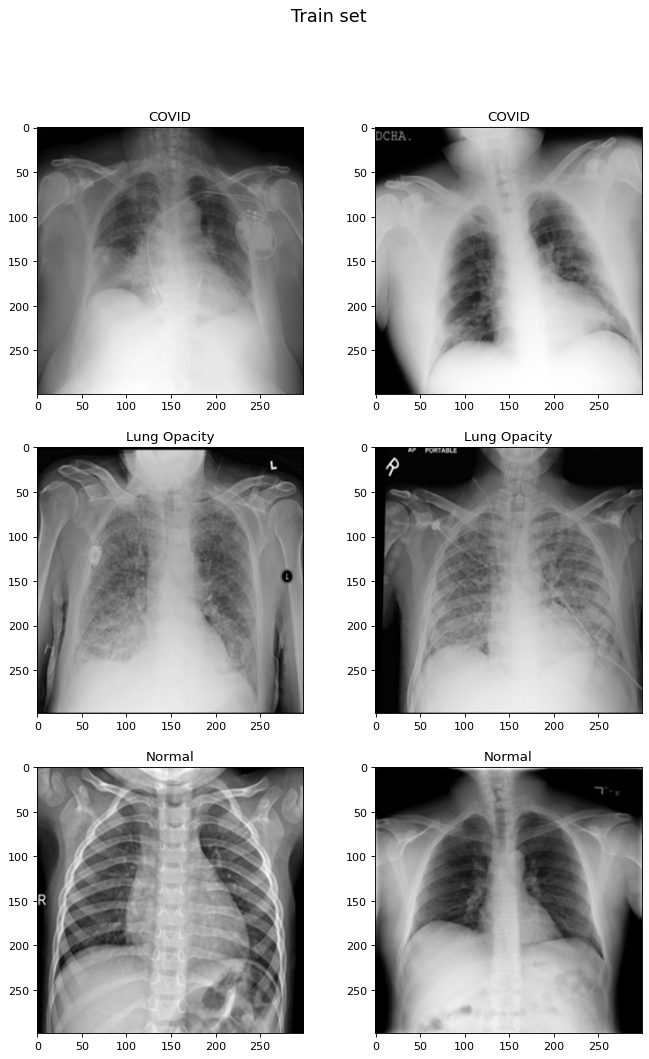

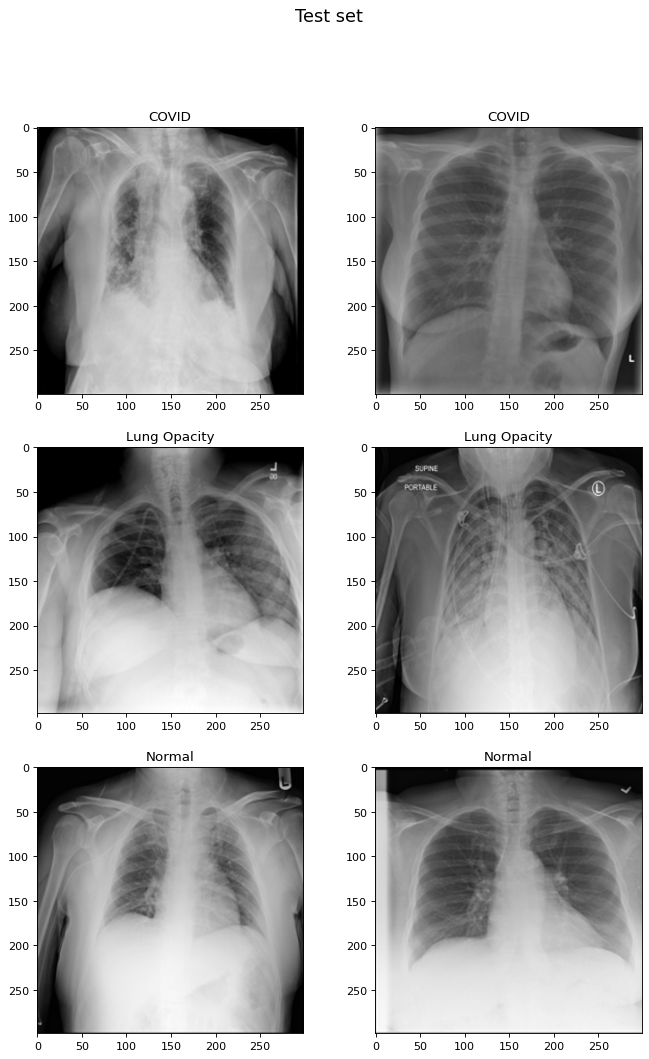

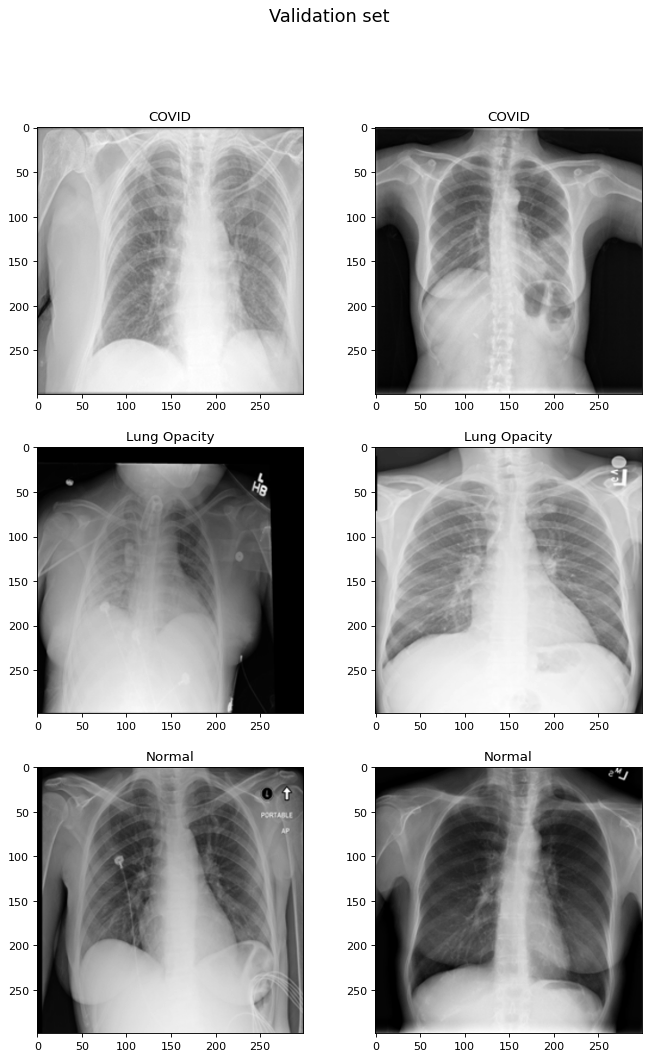

In [ ]:
def plot_sample(dataset_dir=DATASET_DIRNAME, SPLIT_SET=SPLIT_SET, CLASSES=CLASSES):
  # set color map of matplotlib
  cmap = 'gray'
  plt.set_cmap(cmap)
  
  for split_set_name in SPLIT_SET.keys():
    i = 1
    j = len(CLASSES.keys())
    fig = plt.figure(num=None, figsize=(10, 5*j), dpi=80, facecolor='w', edgecolor='k', constrained_layout=False, clear=True)
    fig.canvas.set_window_title(f'{split_set_name} set')
    fig.suptitle(f'{SPLIT_SET[split_set_name][1]} set', fontsize=16)
    for klass_dir_name in CLASSES.keys():
      _images_list = os.listdir(Path(dataset_dir)/ split_set_name / klass_dir_name)
      random_indices = np.random.randint(0, len(_images_list), size=2)
      random_images = np.array(_images_list)[random_indices.astype(int)]

      ax = fig.add_subplot(f"{j}2{i}")
      ax.set_title(f"{CLASSES[klass_dir_name][1]}")
      ax.imshow(mpimg.imread(f'{Path(dataset_dir)/ split_set_name /\
                                        klass_dir_name}/{random_images[0]}'))
      i += 1
      ax = fig.add_subplot(f"{j}2{i}")
      ax.set_title(f"{CLASSES[klass_dir_name][1]}")
      ax.imshow(mpimg.imread(f'{Path(dataset_dir)/ split_set_name /\
                                        klass_dir_name}/{random_images[1]}'))
      i += 1
    plt.show();

plot_sample(dataset_dir=DATASET_DIRNAME, SPLIT_SET=SPLIT_SET, CLASSES=CLASSES)

## Augmentation, transformation and data loader



We want to use data augmentation only on `train set`. We will not `test or validation set`.

We have to resize image by `224x224` which is the expected size of our transfer learning models.

All pre-trained [models](https://pytorch.org/vision/stable/models.html) expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean` = [`0.485`, `0.456`, `0.406`] and `std` = [`0.229`, `0.224`, `0.225`].

We can use the following transform to normalize:
```
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```

In [ ]:
# normalize mean and std according to
# pytorch models description https://pytorch.org/vision/stable/models.html
norm_mean, norm_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# norm_mean, norm_std = [0.456], [0.224]

# train transformation with data augmentation
train_transform = transforms.Compose([
  # transforms.RandomResizedCrop(size=227, scale=(0.8, 1.0)),
  # transforms.RandomRotation(degrees=15),
  # transforms.CenterCrop(size=224),
  # transforms.RandomHorizontalFlip(),
  transforms.Resize(size=224),
  # transforms.Grayscale(num_output_channels=3),
  transforms.ToTensor(),
  # transforms.Lambda(lambda x: x.repeat(1, 1, 1) ),
  # transforms.Normalize(mean=norm_mean, std=norm_std)                
])

# transforms.Lambda(lambda x: x.repeat(3, 1, 1) )

# test transformation without data augmentation
test_transform = transforms.Compose([
  # transforms.Resize(size=227),
  # transforms.CenterCrop(size=224),
  transforms.Resize(size=224),
  # transforms.Grayscale(num_output_channels=3),
  transforms.ToTensor(),
  # transforms.Lambda(lambda x: x.repeat(1, 1, 1) ),
  # transforms.Normalize(mean=norm_mean, std=norm_std)
])

In [ ]:
_dataset_path_dir = Path(DATASET_PATH)

train_dataset = datasets.ImageFolder(
    _dataset_path_dir / 'train',
    transform=train_transform
)
test_dataset = datasets.ImageFolder(
    _dataset_path_dir / 'test',
    transform=test_transform
)
val_dataset = datasets.ImageFolder(
    _dataset_path_dir / 'val',
    transform=test_transform
)


In [ ]:
# # Grayscale image
# img = np.array(mpimg.imread(test_dataset.imgs[0][0]))
# img.shape
# plt.imshow(img)
# plt.show();
# stacked_img = np.stack((img,)*3, axis=-1)
# stacked_img.shape
# plt.imshow(stacked_img)
# plt.show();

In [ ]:
# # RGB image
# img = np.array(mpimg.imread("/content/gdrive/MyDrive/ML/assets/05283.jpg"))
# img.shape

In [ ]:
# Data loader
# Usefull because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = BATCH_SIZE

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
# # import torch
# # from torch.utils.data import Dataset, DataLoader

# # import numpy as np


# class MyDataset(torch.utils.data.Dataset):
#     def __init__(self, data, target, transform=None):
#         self.data = torch.from_numpy(data).float()
#         self.target = torch.from_numpy(target).long()
#         self.transform = transform
        
#     def __getitem__(self, index):
#         x = self.data[index]
#         y = self.target[index]
        
#         if self.transform:
#             x = self.transform(x)
        
#         return x, y
    
#     def __len__(self):
#         return len(self.data)


# numpy_data = np.random.randn(100, 3, 224, 224)
# numpy_target = np.random.randint(0, 3, size=(100))

# dataset = MyDataset(numpy_data, numpy_target)
# loader = torch.utils.data.DataLoader(
#     dataset,
#     batch_size=10,
#     shuffle=True,
#     # num_workers=2,
#     # pin_memory=torch.cuda.is_available()
# )

# for batch_idx, (data, target) in enumerate(loader):
#     print('Batch idx {}, data shape {}, target shape {}'.format(
#         batch_idx, data.shape, target.shape))

In [ ]:
# val_loader.dataset.class_to_idx
# loader.dataset.target

## Utility Functions

Some helper functions are defined in this section to reuse code and encapsulate some processes.

### Utils for Training and Validation

In [ ]:
#@title **Evaluation Method**

#@markdown  *Confusion Matrix*, *Precision*, *Recall*, *F1 Scrore*, and Validation *Accuracy* are the standard evaluation method for the classification model.

#@markdown **Confusion Matrix** as the name suggests gives us a matrix as output and describes the complete performance of the model.

#@markdown | Actual / Predicted| Positive               | Negetive               |
#@markdown | :---------------- |   :-----------------:  |  :-----------------:   |
#@markdown |  Positive         | True Positive (**TP**) | False Negetive (**FN**)|
#@markdown |  Negetive         | False Positive (**FP**)| True Negetive (**TN**) |

#@markdown **Precision** is the number of correctly identified cases among all the identified cases. 
#@markdown $$Precision, P = \frac{TP}{TP + FP}$$

#@markdown **Recall** is the number of correctly identified cases from all the positive representations. 
#@markdown $$Recall, R = \frac{TP}{TP + FN}$$

#@markdown **F1 score** is the harmonic average of precision and recall.
#@markdown $$F1Scrore, F1 = 2\times \frac{P \times R}{P + R}$$

#@markdown **Accuracy** is the ratio of number of correct predictions to the total number of input sampols.
#@markdown $$Accuracy = \frac{Number of Correct predictions}{Total number of predictions made}$$

In [ ]:
# training function
def fit(model, criterion, optimizer, dataloader, device):
  model.train()
  train_running_loss = 0.0
  train_running_correct = 0

  for inputs, targets in dataloader:
    # print(f"inputs len={len(inputs)}, inputs shape={ inputs.shape}")

    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # store loss and correct
    train_running_loss += loss.item()
    train_running_correct += (predictions == targets).sum().item()

    # Backward and optimize
    loss.backward()
    optimizer.step()
      
  train_loss = train_running_loss/len(dataloader.dataset)
  # train_accuracy = 100. * train_running_correct/len(dataloader.dataset)
  train_accuracy = train_running_correct/len(dataloader.dataset)
  return train_loss, train_accuracy

In [ ]:
# validation function
def validate(model, criterion, optimizer, dataloader, device):
  model.eval()
  val_running_loss = 0.0
  val_running_correct = 0

  with torch.no_grad():
    for inputs, targets in dataloader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Get prediction
      # torch.max returns both max and argmax
      _, predictions = torch.max(outputs, 1)

      val_running_loss += loss.item()
      val_running_correct += (predictions == targets).sum().item()
    
    val_loss = val_running_loss/len(dataloader.dataset)
    # val_accuracy = 100. * val_running_correct/len(dataloader.dataset)        
    val_accuracy = val_running_correct/len(dataloader.dataset)        
    return val_loss, val_accuracy

In [ ]:
# training function
def train_and_validate(model, 
                       criterion, 
                       optimizer, 
                       train_loader, 
                       test_loader, 
                       device, 
                       epochs):
  train_loss , train_accuracy = [], []
  val_loss, val_accuracy = [], []
  for epoch in range(epochs):
    t0 = datetime.now()
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = \
                    fit(model, criterion, optimizer, train_loader, device)
    val_epoch_loss, val_epoch_accuracy = \
                    validate(model, criterion, optimizer, test_loader, device)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)

    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    dt = datetime.now() - t0

    print(f"Train Loss: {train_epoch_loss:.6f}, Train Acc: {train_epoch_accuracy:.6f}")
    print(f"Val Loss: {val_epoch_loss:.6f}, Val Acc: {val_epoch_accuracy:.6f}")
    print(f"Duration: {dt}")
  return train_loss , train_accuracy, val_loss, val_accuracy

### Utils to Plot History and Save Images

In [ ]:
# A function to plot train and val loss
def plot_loss(train_loss, 
              val_loss, 
              train_label='train loss', 
              val_label='val loss',
              title="",
              xlabel="",
              ylabel="",
              save=False,
              save_path=None):
  plt.plot(train_loss, label=train_label)
  plt.plot(val_loss, label=val_label)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  if save and save_path:
    try:
      plt.savefig(save_path)
    except Exception as e:
      print("Figure save failed!")
      raise e
  plt.show()

# A function to plot train and val accuracy
def plot_accuracy(train_acuracy, 
              val_acuracy, 
              train_label='train accuracy', 
              val_label='val accuracy',
              title="",
              xlabel="",
              ylabel="",
              save=False,
              save_path=None):
  plt.plot(train_acuracy, label=train_label)
  plt.plot(val_acuracy, label=val_label)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  if save and save_path:
    try:
      plt.savefig(save_path)
    except Exception as e:
      print("Figure save failed!")
      raise e
  plt.show()

In [ ]:
def plot_show_save(data, color, title, xlabel, ylabel, file_path, figsize=(10, 7)):
  plt.figure(figsize=figsize)
  plt.plot(data, color=color, label=title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.savefig(file_path)
  plt.show();

### Utils to Save Model Checkpoint

In [ ]:
# A function to save model checkpoint
def save_model_checkpoint(model_name, 
                          model, 
                          criterion, 
                          optimizer, 
                          epochs, 
                          batch_size,
                          train_history,
                          validation_history,
                          file_name,
                          destination=None, 
                          overwrite=False):
  if  destination:
    file_path = Path(destination)/ f"{file_name}.pth"
  else:
    file_path = Path(f"{file_name}.pth")
  
  if (not overwrite) and file_path.exists():
    print(f"File '{file_path}' already exist.")
    file_path = file_path[:-4] + f"{str(datetime.now())}" + '.pth'
    print(f"File renamed with current datetime as '{file_path}'")
  try:
    if destination and (not Path(destination).exists()):
      Path(destination).mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), file_path)
    torch.save({
            'model_name': model_name,
            'batch_size': batch_size,
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            'train_history': train_history,
            'validation_history': validation_history,
            }, file_path)
    print(f"Model checkpoint saved at '{file_path}'")
  except Exception as e:
    print(f"Model checkpoint did not save!")
    raise(e)
    return
  return file_path

# A function that convert loss, accuracy list to dictionary
# It is usefull during save model checkpoint
def prepare_history_dict(loss, accuracy):
  loss_d = {k:v for k, v in enumerate(loss)}
  accuracy = {k:v for k, v in enumerate(accuracy)}
  history = {
      'loss': loss_d,
      'accuracy': accuracy
  }
  return history

# A function that convert history dictionary to loss, accuracy list
# It is usefull during load saved model checkpoint
def retrieve_history_list(history):
  loss = [history['loss'][i] for i in range(len(history['loss']))]
  accuracy = [history['accuracy'][i] for i in range(len(history['accuracy']))]
  return loss, accuracy

# A function to load saved model checkpoint
def load_model_checkpoint(saved_model_checkpoint_path):
  # load the model checkpoint
  checkpoint = torch.load(saved_model_checkpoint_path)
  return checkpoint

### Utils to Show State Dict

In [ ]:
# A function to print model and/or optimizer state_dict
def print_state_dict(model=None, optimizer=None):
  # model's state_dict
  if model:
    print("model's state_dict:")
    for param_tensor in model.state_dict():
      print(f"{param_tensor} \t {model.state_dict()[param_tensor].size()}")
  if optimizer:
    # optimizer's state_dict
    print("optimizer's state_dict:")
    for var_name in optimizer.state_dict():
      print(f"{var_name} \t {optimizer.state_dict()[var_name]}")
  if not (model and optimizer):
    print("No model or optimizer provided. Skipping!")


# Model Construction for Initial Trainig

**NOTE**: This block may not need during *`Resume Training`*

## Define transfer learning models

We are going to apply transfer learning technique based on the following models:


*   [VGG](https://arxiv.org/abs/1409.1556)
*   [ResNet](https://arxiv.org/abs/1512.03385)
*   [DenseNet](https://arxiv.org/abs/1608.06993)
*   [AlexNet](https://arxiv.org/abs/1404.5997)


In [ ]:
MODELS = {
    # 'moco-v1': ['https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v1_200ep/moco_v1_200ep_pretrain.pth.tar', 'pth'],
    # 'moco-v2': ['https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar', 'pth'],
    # 'byol': ['https://storage.googleapis.com/deepmind-byol/checkpoints/pretrain_res50x1.pkl', 'pkl'],
    # 'swav': ['https://dl.fbaipublicfiles.com/deepcluster/swav_800ep_pretrain.pth.tar', 'pth'],
    # 'deepcluster-v2': ['https://dl.fbaipublicfiles.com/deepcluster/deepclusterv2_800ep_pretrain.pth.tar', 'pth'],
    # 'sela-v2': ['https://dl.fbaipublicfiles.com/deepcluster/selav2_400ep_pretrain.pth.tar', 'pth'],
    # 'infomin': ['https://www.dropbox.com/sh/87d24jqsl6ra7t2/AAAzMTynP3Qc8mIE4XWkgILUa/InfoMin_800.pth', 'pth'],
    # 'insdis': ['https://www.dropbox.com/sh/87d24jqsl6ra7t2/AACcsSIt1_Njv7GsmsuzZ6Sta/InsDis.pth', 'pth'],
    # 'pirl': ['https://www.dropbox.com/sh/87d24jqsl6ra7t2/AADN4jKnvTI0U5oT6hTmQZz8a/PIRL.pth', 'pth'],
    # 'pcl-v1': ['https://storage.googleapis.com/sfr-pcl-data-research/PCL_checkpoint/PCL_v1_epoch200.pth.tar', 'pth'],
    # 'pcl-v2': ['https://storage.googleapis.com/sfr-pcl-data-research/PCL_checkpoint/PCL_v2_epoch200.pth.tar', 'pth'],
    # 'barlowtwins':['https://dl.fbaipublicfiles.com/barlowtwins/ep1000_bs2048_lrw0.2_lrb0.0048_lambd0.0051/resnet50.pth','pth'],
    # 'ChestX-ray14':['https://zenodo.org/record/5205234/files/chestxray14.pth.tar?download=1', 'pth'],
    # 'ChexPert':['https://zenodo.org/record/5205234/files/chexpert.pth.tar?download=1', 'pth'],
    'ImageNet_ChestX-ray14':['https://zenodo.org/record/5205234/files/ImageNet_chestxray14.pth.tar?download=1', 'pth'],
    # 'ImageNet_ChexPert':['https://zenodo.org/record/5205234/files/ImageNet_chexpert.pth.tar?download=1', 'pth'],
}

def download_pretrained_models(pretrained_models_path='models'):
  for model_name, (url, file_format) in MODELS.items():
    if url and file_format:
      dst = os.path.join(pretrained_models_path, f'{model_name}.{file_format}')
      if not os.path.isfile(dst):
        print(f'Downloading {model_name} from {url} to {dst}')
        os.system(f"wget {url} -O {dst}")
        # subprocess.run(['wget', url, '-O', dst])
      else:
        print(f'Found {model_name} at {dst}')


def rename(d):
  unwanted_prefixes = {
    'simclr-v1': '',
    'simclr-v2': '',
    'byol': '',
    'swav': 'module.',
    'deepcluster-v2': 'module.',
    'sela-v2': 'module.',
    'moco-v1': 'module.encoder_q.',
    'moco-v2': 'module.encoder_q.',
    'cmc': 'module.encoder1.',
    'infomin': 'module.encoder.',
    'insdis': 'module.encoder.',
    'pirl': 'module.encoder.',
    'pcl-v1': 'module.encoder_q.',
    'pcl-v2': 'module.encoder_q.',
    'barlowtwins': '',
    'ChestX-ray14': '',
    'ChexPert': 'module.',
    'ImageNet_ChestX-ray14': '',
    'ImageNet_ChexPert': 'module.',

  }
  prefix = unwanted_prefixes[model_name]
  l = len(prefix)
  new_d = {}
  for key in d.keys():
    if prefix in key:
      new_d[key[l:]] = d[key]
    else:
      new_d[key] = d[key]
  return new_d

def remove_keys(d):
  for key in list(d.keys()):
    if 'module.jigsaw' in key or 'module.head_jig' in key:
      print('warning, jigsaw stream in model')
      d.pop(key)
    elif 'projection' in key or 'prototypes' in key or 'fc' in key or 'linear' in key or 'head' in key:
      print(f'removed {key}')
      d.pop(key)
  return d

def load_resnet(model_name):
  model = models.resnet50(pretrained=False)

  n_features = model.fc.in_features
  print(f"n_features={n_features}")

  del model.fc

  path = os.path.join('models', f'{model_name}.pth')
  print(f"path={path}")
  state_dict = torch.load(path, map_location=torch.device('cpu'))
  print(f"state_dict={state_dict.keys()}")

  if 'state_dict' in state_dict:
      state_dict = state_dict['state_dict']
  elif 'model' in state_dict:
      state_dict = state_dict['model']
  elif 'resnet' in state_dict:
      state_dict = state_dict['resnet']
  
  if model_name == 'simclr-v2':
    state_dict_keys = [k for k in state_dict.keys() if 'tracked' not in k and 'fc' not in k]
    simclr_dict = pickle.load(open('./simclr_keys.pkl', 'rb'))
    state_dict = {key: state_dict[tf_key] for key, tf_key in simclr_dict.items()}
  else:
    state_dict = rename(state_dict)
    state_dict = remove_keys(state_dict)

  model.load_state_dict(state_dict)

  # We're doing K-class classification
  try:
    model.fc = nn.Linear(n_features, K)
  except Exception as e:
    print("ERROR at: model.fc = nn.Linear(n_features, K)")
    raise e

  # Use GPU if available
  print(device)
  model.to(device)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  return model, criterion, optimizer


In [ ]:
!mkdir models

In [ ]:
download_pretrained_models(pretrained_models_path='models')

In [ ]:
model_name = "ImageNet_ChestX-ray14"
model_resnet50, criterion_resnet50, optimizer_resnet50 = load_resnet(model_name)

n_features=2048
path=models/ImageNet_ChestX-ray14.pth
state_dict=dict_keys(['epoch', 'lossMIN', 'state_dict', 'optimizer', 'scheduler'])
removed fc.0.weight
removed fc.0.bias
cuda:0


In [ ]:
print(model_resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
if True:
  epochs_resnet50 = 2

  train_loss_resnet50, train_accuracy_resnet50, val_loss_resnet50, val_accuracy_resnet50 = train_and_validate(
            model=model_resnet50, 
            criterion=criterion_resnet50, 
            optimizer=optimizer_resnet50, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            device=device, 
            epochs=epochs_resnet50)

Epoch 1 of 2


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Loss: 0.010010, Train Acc: 0.879685
Val Loss: 0.032054, Val Acc: 0.552294
Duration: 0:03:24.833496
Epoch 2 of 2
Train Loss: 0.005438, Train Acc: 0.939450
Val Loss: 0.019659, Val Acc: 0.791284
Duration: 0:03:24.156958


In [ ]:
# !mkdir checkpoints

In [ ]:
if True:
  saved_model_list = {}
  saved_model_destination = 'checkpoints'
  checkpoint_file_name_resnet50= f'resnet50-epochs-{epochs_resnet50}-{datetime.now()}'
  train_history_resnet50 = prepare_history_dict(loss=train_loss_resnet50, 
                                            accuracy=train_accuracy_resnet50)
  validation_history_resnet50 = prepare_history_dict(loss=val_loss_resnet50, 
                                                  accuracy=val_accuracy_resnet50)
  model_path_resnet50 = save_model_checkpoint(
                        model_name='resnet50', 
                        model=model_resnet50, 
                        criterion=criterion_resnet50, 
                        optimizer=optimizer_resnet50, 
                        epochs=epochs_resnet50, 
                        batch_size=batch_size,
                        train_history=train_history_resnet50,
                        validation_history=validation_history_resnet50,
                        file_name=checkpoint_file_name_resnet50,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_resnet50:
    saved_model_list['resnet50'] = model_path_resnet50
    print(f"model saved at {model_path_resnet50}")
  else:
    raise Exception("Error: Model did not saved succesfully!")

Model checkpoint saved at 'checkpoints/resnet50-epochs-2-2021-11-05 16:56:07.144966.pth'
model saved at checkpoints/resnet50-epochs-2-2021-11-05 16:56:07.144966.pth


### Repeate Training

In [ ]:
epochs_resnet50 = 4

In [ ]:
# model_path_resnet50 = "checkpoints/resnet50-epochs-8-11_05_2021_17_04_17.pth"
model_checkpoint_path_dict = {
    'resnet50': Path(model_path_resnet50)
}
print(model_checkpoint_path_dict)

{'resnet50': PosixPath('checkpoints/resnet50-epochs-26-11_05_2021_17_45_30.pth')}


In [ ]:
# Load Saved Model Checkpoint
if True:
  # pretrained resnet50 model
  model_resnet50 = models.resnet50(pretrained=True)

  # Freeze weights
  for param in model_resnet50.parameters():
    param.requires_grad = False
  
  # see the number of features
  n_features_resnet50 = model_resnet50.fc.in_features
  print(n_features_resnet50)

  # We're doing K-class classification
  model_resnet50.fc = nn.Linear(n_features_resnet50, K)

  # Use GPU if available
  print(device)
  model_resnet50.to(device)

  # Loss and optimizer
  criterion_resnet50 = nn.CrossEntropyLoss()
  optimizer_resnet50 = torch.optim.Adam(model_resnet50.parameters())

  # load the model checkpoint
  checkpoint_resnet50 = load_model_checkpoint(
                      model_checkpoint_path_dict.get('resnet50'))

  # load model weights state_dict
  model_resnet50.load_state_dict(checkpoint_resnet50['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')

  # load trained optimizer state_dict
  optimizer_resnet50.load_state_dict(checkpoint_resnet50['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')

  # Previous epochs
  epochs_resnet50_pre = checkpoint_resnet50['epoch']
  print(f"Previously trained for {epochs_resnet50_pre} number of epochs...")

  # load the criterion
  criterion_resnet50 = checkpoint_resnet50['loss']
  print('Trained model loss function loaded...')

  train_loss_resnet50_pre, train_accuracy_resnet50_pre = retrieve_history_list(
                                checkpoint_resnet50['train_history'])
  val_loss_resnet50_pre, val_accuracy_resnet50_pre = retrieve_history_list(
                                checkpoint_resnet50['validation_history'])

2048
cuda:0
Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Previously trained for 26 number of epochs...
Trained model loss function loaded...


In [ ]:
# Resume Training
if True:
  new_epochs = epochs_resnet50
  # train for more epochs
  epochs_resnet50_new = new_epochs
  print(f"Train for {epochs_resnet50_new} more epochs...")

  # resume train
  train_loss_resnet50_new, train_accuracy_resnet50_new, val_loss_resnet50_new, \
  val_accuracy_resnet50_new = train_and_validate(
        model=model_resnet50, 
        criterion=criterion_resnet50, 
        optimizer=optimizer_resnet50, 
        train_loader=train_loader, 
        test_loader=test_loader, 
        device=device, 
        epochs=epochs_resnet50_new)
  
  # togather all things
  train_loss_resnet50_all = train_loss_resnet50_pre + train_loss_resnet50_new
  train_accuracy_resnet50_all = train_accuracy_resnet50_pre \
                              + train_accuracy_resnet50_new
  val_loss_resnet50_all = val_loss_resnet50_pre + val_loss_resnet50_new
  val_accuracy_resnet50_all = val_accuracy_resnet50_pre + val_accuracy_resnet50_new
  epochs_resnet50_all = epochs_resnet50_pre + epochs_resnet50_new

Train for 4 more epochs...
Epoch 1 of 4
Train Loss: 0.003144, Train Acc: 0.963696
Val Loss: 0.005209, Val Acc: 0.946330
Duration: 0:01:40.331956
Epoch 2 of 4
Train Loss: 0.003291, Train Acc: 0.963172
Val Loss: 0.005069, Val Acc: 0.947248
Duration: 0:01:40.135119
Epoch 3 of 4
Train Loss: 0.002990, Train Acc: 0.965007
Val Loss: 0.005152, Val Acc: 0.944037
Duration: 0:01:39.958872
Epoch 4 of 4
Train Loss: 0.003179, Train Acc: 0.965662
Val Loss: 0.004988, Val Acc: 0.946330
Duration: 0:01:39.750894


In [ ]:
# !mkdir logs

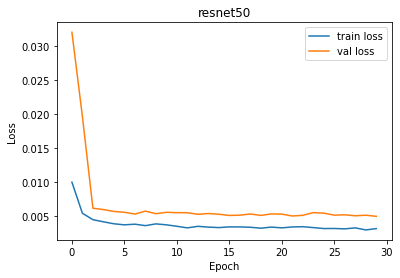

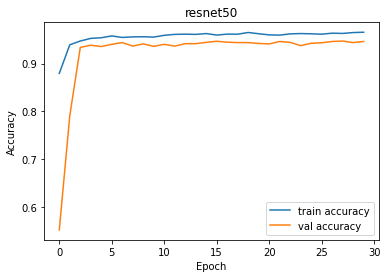

In [ ]:
# Plot and save logs of train and val loss-accuracy
logs_destination = 'logs'
if True:
  # plot train and val loss
  fig_path = Path(logs_destination) / \
      f"resnet50-epochs-{epochs_resnet50_all}-loss-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_loss(train_loss=train_loss_resnet50_all, 
            val_loss=val_loss_resnet50_all, 
            train_label='train loss', 
            val_label='val loss',
            title="resnet50",
            xlabel="Epoch",
            ylabel="Loss",
            save=True,
            save_path=fig_path)

  # plot train and val accuracy
  fig_path = Path(logs_destination) / \
      f"resnet50-epochs-{epochs_resnet50_all}-accuracy-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_accuracy(train_acuracy=train_accuracy_resnet50_all, 
                val_acuracy=val_accuracy_resnet50_all, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="resnet50",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=True,
                save_path=fig_path)

In [ ]:
# Save Latest Training Checkpoint Again 
if model_checkpoint_path_dict.get('resnet50', None):
  # save model checkpoint again
  checkpoint_file_name_resnet50= \
                  f"resnet50-epochs-{epochs_resnet50_all}-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}"
  train_history_resnet50_all = \
                  prepare_history_dict(loss=train_loss_resnet50_all, 
                                      accuracy=train_accuracy_resnet50_all)
  validation_history_resnet50_all = \
                  prepare_history_dict(loss=val_loss_resnet50_all, 
                                      accuracy=val_accuracy_resnet50_all)
  
  model_path_resnet50 = save_model_checkpoint(
                        model_name='resnet50', 
                        model=model_resnet50, 
                        criterion=criterion_resnet50, 
                        optimizer=optimizer_resnet50, 
                        epochs=epochs_resnet50_all, 
                        batch_size=batch_size,
                        train_history=train_history_resnet50_all,
                        validation_history=validation_history_resnet50_all,
                        file_name=checkpoint_file_name_resnet50,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_resnet50:
    saved_model_list['resnet50'] = model_path_resnet50
  else:
    raise Exception("Error: Model did not saved succesfully!")

Model checkpoint saved at 'checkpoints/resnet50-epochs-30-11_05_2021_17_53_24.pth'


In [ ]:
# torch.cuda.memory_summary(device=None, abbreviated=False)
# torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

### Save checkpoints and Logs to Google drive

In [ ]:
if True:
  saved_model_destination = "checkpoints"
  # print(*os.listdir(GOOGLE_DRIVE_MOUNTED_DIRNAME), sep='\n')
  gdrive_models_path = f"gdrive/MyDrive/ML/covid19/checkpoints"
  saved_logs_destination = 'logs'
  gdrive_logs_destination = f"gdrive/MyDrive/ML/covid19/logs-new"
  # see inside gdrive
  # print(*os.listdir(GOOGLE_DRIVE_MOUNTED_DIRNAME), sep='\n')
  # # select location of gdrive
  # gdrive_models_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_MODELS_PATH}'
  # print(*os.listdir(gdrive_models_path), sep='\n')

  # copy colab models to gdrive
  # how to : https://stackoverflow.com/q/59710439/8520849
  # !cp -av 'models' 'gdrive/MyDrive/ML/concrete_crack_detection/models'
  # os.system("cp -av {} {}".format(saved_model_destination, gdrive_models_path))
  copytree(src=saved_model_destination, dst=gdrive_models_path)
  copytree(src=saved_logs_destination, dst=gdrive_logs_destination)

In [ ]:
!cp "checkpoints/resnet50-epochs-30-11_05_2021_17_53_24.pth"  "gdrive/MyDrive/ML/covid19/checkpoints"

In [ ]:
!kaggle datasets init -p /content/checkpoints

Data package template written to: /content/checkpoints/dataset-metadata.json


In [ ]:
!kaggle datasets create -p /content/checkpoints

Default slug detected, please change values before uploading


In [ ]:
!kaggle datasets status /content/checkpoints

Invalid dataset specification /content/checkpoints


### VGG

Prepare VGG model for transfer learning.

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # pretrained vgg16 model
  model_vgg16 = models.vgg16(pretrained=True)

  # Freeze weights
  for param in model_vgg16.parameters():
    param.requires_grad = False

  # see model detail
  print("Pretrained Model")
  print(model_vgg16)

  # We want to replace the 'classifier'
  print(model_vgg16.classifier)

  # see the number of features
  n_features_vgg16 = model_vgg16.classifier[0].in_features
  print(n_features_vgg16)

  # We're doing K-class classification
  model_vgg16.classifier = nn.Linear(n_features_vgg16, K)

  # Let's see what the model is now
  print("Customized Model")
  print(model_vgg16)

  # Use GPU if available
  print(device)
  model_vgg16.to(device)

  # Loss and optimizer
  criterion_vgg16 = nn.CrossEntropyLoss()
  optimizer_vgg16 = torch.optim.Adam(model_vgg16.parameters())

### ResNet

Prepare ResNet model for transfer learning.

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # pretrained resnet18 model
  model_resnet18 = models.resnet18(pretrained=True)

  # Freeze weights
  for param in model_resnet18.parameters():
    param.requires_grad = False

  # see model detail
  print("Pretrained Model")
  print(model_resnet18)

  # We want to replace the 'fc'
  print(model_resnet18.fc)

  # see the number of features
  n_features_resnet18 = model_resnet18.fc.in_features
  print(n_features_resnet18)

  # We're doing K-class classification
  model_resnet18.fc = nn.Linear(n_features_resnet18, K)

  # Let's see what the model is now
  print("Customized Model")
  print(model_resnet18)

  # Use GPU if available
  print(device)
  model_resnet18.to(device)

  # Loss and optimizer
  criterion_resnet18 = nn.CrossEntropyLoss()
  optimizer_resnet18 = torch.optim.Adam(model_resnet18.parameters())

### DenseNet

Prepare DenseNet model for transfer learning.

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # pretrained densenet161 model
  model_densenet161 = models.densenet161(pretrained=True)

  # Freeze weights
  for param in model_densenet161.parameters():
    param.requires_grad = False

  # see model detail
  print("Pretrained Model")
  print(model_densenet161)

  # We want to replace the 'classifier'
  print(model_densenet161.classifier)

  # see the number of features
  n_features_densenet161 = model_densenet161.classifier.in_features
  print(n_features_densenet161)

  # We're doing K-class classification
  model_densenet161.classifier = nn.Linear(n_features_densenet161, K)

  # Let's see what the model is now
  print("Customized Model")
  print(model_densenet161)

  # Use GPU if available
  print(device)
  model_densenet161.to(device)

  # Loss and optimizer
  criterion_densenet161 = nn.CrossEntropyLoss()
  optimizer_densenet161 = torch.optim.Adam(model_densenet161.parameters())

### AlexNet

Prepare AlexNet model for transfer learning.

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # pretrained alexnet model
  model_alexnet = models.alexnet(pretrained=True)

  # Freeze weights
  for param in model_alexnet.parameters():
    param.requires_grad = False

  # see model detail
  print("Pretrained Model")
  print(model_alexnet)

  # We want to replace the 'classifier'
  print(model_alexnet.classifier)

  # see the number of features
  n_features_alexnet = model_alexnet.classifier[1].in_features
  print(n_features_alexnet)

  # We're doing K-class classification
  model_alexnet.classifier = nn.Linear(n_features_alexnet, K)

  # Let's see what the model is now
  print("Customized Model")
  print(model_alexnet)

  # Use GPU if available
  print(device)
  model_alexnet.to(device)

  # Loss and optimizer
  criterion_alexnet = nn.CrossEntropyLoss()
  optimizer_alexnet = torch.optim.Adam(model_alexnet.parameters())

# Ininitial Training Block

**NOTE**: This block of cells may not required during *`Resume Training`*

## Train and Evaluate Models



In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # Some common variables
  epochs = INITIAL_TRAINING_EPOCHS

In [ ]:
print(device)

cuda:0


In [ ]:
# !wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip
# !unzip -qq -o "5y9wdsg2zt-2.zip"
# !unrar x 'Concrete Crack Images for Classification.rar'

In [ ]:
# !mkdir rgbdata
# !mkdir rgbdata/train
# !mkdir rgbdata/test
# !mkdir rgbdata/train/crack
# !mkdir rgbdata/train/noncrack
# !mkdir rgbdata/test/crack
# !mkdir rgbdata/test/noncrack

In [ ]:
# !mv Positive/* rgbdata/train/crack
# !mv Negative/* rgbdata/train/noncrack

# cracks = os.listdir('rgbdata/train/crack')
# noncracks = os.listdir('rgbdata/train/noncrack')
# for i in range(200):
#   shutil.move(f"rgbdata/train/crack/{cracks[i]}", f"rgbdata/test/crack/")
#   shutil.move(f"rgbdata/train/noncrack/{noncracks[i]}", f"rgbdata/test/noncrack/")

### VGG

In [ ]:
# train the model
if ACTIVE_INITIAL_TRAINING_STAGE:
  epochs_vgg16 = epochs

  train_loss_vgg16, train_accuracy_vgg16, val_loss_vgg16, val_accuracy_vgg16 = train_and_validate(
            model=model_vgg16, 
            criterion=criterion_vgg16, 
            optimizer=optimizer_vgg16, 
            # train_loader=loader, # train_loader, 
            # test_loader= loader, # test_loader, 
            train_loader=train_loader, 
            test_loader=test_loader,
            device=device, 
            epochs=epochs_vgg16)

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # plot train and val loss
  plot_loss(train_loss=train_loss_vgg16, 
            val_loss=val_loss_vgg16, 
            train_label='train loss', 
            val_label='val loss',
            title="vgg16",
            xlabel="Epoch",
            ylabel="Loss",
            save=False,
            save_path=None)

  # plot train and val accuracy
  plot_accuracy(train_acuracy=train_accuracy_vgg16, 
                val_acuracy=val_accuracy_vgg16, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="vgg16",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=False,
                save_path=None)

### ResNet

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  epochs_resnet18 = epochs

  train_loss_resnet18, train_accuracy_resnet18, val_loss_resnet18, val_accuracy_resnet18 = train_and_validate(
            model=model_resnet18, 
            criterion=criterion_resnet18, 
            optimizer=optimizer_resnet18, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            device=device, 
            epochs=epochs_resnet18)

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # plot train and val loss
  plot_loss(train_loss=train_loss_resnet18, 
            val_loss=val_loss_resnet18, 
            train_label='train loss', 
            val_label='val loss',
            title="resnet18",
            xlabel="Epoch",
            ylabel="Loss",
            save=False,
            save_path=None)

  # plot train and val accuracy
  plot_accuracy(train_acuracy=train_accuracy_resnet18, 
                val_acuracy=val_accuracy_resnet18, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="resnet18",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=False,
                save_path=None)

### DenseNet

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  epochs_densenet161 = epochs

  train_loss_densenet161, train_accuracy_densenet161, val_loss_densenet161, val_accuracy_densenet161 = train_and_validate(
            model=model_densenet161, 
            criterion=criterion_densenet161, 
            optimizer=optimizer_densenet161, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            device=device, 
            epochs=epochs_densenet161)

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # plot train and val loss
  plot_loss(train_loss=train_loss_densenet161, 
            val_loss=val_loss_densenet161, 
            train_label='train loss', 
            val_label='val loss',
            title="densenet161",
            xlabel="Epoch",
            ylabel="Loss",
            save=False,
            save_path=None)

  # plot train and val accuracy
  plot_accuracy(train_acuracy=train_accuracy_densenet161, 
                val_acuracy=val_accuracy_densenet161, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="densenet161",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=False,
                save_path=None)

### AlexNet

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  epochs_alexnet = epochs

  train_loss_alexnet, train_accuracy_alexnet, val_loss_alexnet, val_accuracy_alexnet = train_and_validate(
            model=model_alexnet, 
            criterion=criterion_alexnet, 
            optimizer=optimizer_alexnet, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            device=device, 
            epochs=epochs_alexnet)

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # plot train and val loss
  plot_loss(train_loss=train_loss_alexnet, 
            val_loss=val_loss_alexnet, 
            train_label='train loss', 
            val_label='val loss',
            title="alexnet",
            xlabel="Epoch",
            ylabel="Loss",
            save=False,
            save_path=None)

  # plot train and val accuracy
  plot_accuracy(train_acuracy=train_accuracy_alexnet, 
                val_acuracy=val_accuracy_alexnet, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="alexnet",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=False,
                save_path=None)

## Save and Download Models

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # common variables for saving and retrieving models
  saved_model_list = {}
  saved_model_destination = MODELS_DIRNAME_COLAB

### VGG

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  checkpoint_file_name_vgg16= f'vgg16-epochs-{epochs_vgg16}-{datetime.now()}'
  train_history_vgg16 = prepare_history_dict(loss=train_loss_vgg16, 
                                            accuracy=train_accuracy_vgg16)
  validation_history_vgg16 = prepare_history_dict(loss=val_loss_vgg16, 
                                                  accuracy=val_accuracy_vgg16)
  model_path_vgg16 = save_model_checkpoint(
                        model_name='vgg16', 
                        model=model_vgg16, 
                        criterion=criterion_vgg16, 
                        optimizer=optimizer_vgg16, 
                        epochs=epochs_vgg16, 
                        batch_size=batch_size,
                        train_history=train_history_vgg16,
                        validation_history=validation_history_vgg16,
                        file_name=checkpoint_file_name_vgg16,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_vgg16:
    saved_model_list['vgg16'] = model_path_vgg16
  else:
    raise Exception("Error: Model did not saved succesfully!")

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # see list of saved models
  print(*os.listdir(saved_model_destination), sep='\n')

### ResNet

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  checkpoint_file_name_resnet18= f'resnet18-epochs-{epochs_resnet18}-{datetime.now()}'
  train_history_resnet18 = prepare_history_dict(loss=train_loss_resnet18, 
                                            accuracy=train_accuracy_resnet18)
  validation_history_resnet18 = prepare_history_dict(loss=val_loss_resnet18, 
                                                  accuracy=val_accuracy_resnet18)
  model_path_resnet18 = save_model_checkpoint(
                        model_name='resnet18', 
                        model=model_resnet18, 
                        criterion=criterion_resnet18, 
                        optimizer=optimizer_resnet18, 
                        epochs=epochs_resnet18, 
                        batch_size=batch_size,
                        train_history=train_history_resnet18,
                        validation_history=validation_history_resnet18,
                        file_name=checkpoint_file_name_resnet18,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_resnet18:
    saved_model_list['resnet18'] = model_path_resnet18
  else:
    raise Exception("Error: Model did not saved succesfully!")

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # see list of saved models
  print(*os.listdir(saved_model_destination), sep='\n')

### DenseNet

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  checkpoint_file_name_densenet161= f'densenet161-epochs-{epochs_densenet161}-{datetime.now()}'
  train_history_densenet161 = prepare_history_dict(loss=train_loss_densenet161, 
                                            accuracy=train_accuracy_densenet161)
  validation_history_densenet161 = prepare_history_dict(loss=val_loss_densenet161, 
                                                  accuracy=val_accuracy_densenet161)
  model_path_densenet161 = save_model_checkpoint(
                        model_name='densenet161', 
                        model=model_densenet161, 
                        criterion=criterion_densenet161, 
                        optimizer=optimizer_densenet161, 
                        epochs=epochs_densenet161, 
                        batch_size=batch_size,
                        train_history=train_history_densenet161,
                        validation_history=validation_history_densenet161,
                        file_name=checkpoint_file_name_densenet161,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_densenet161:
    saved_model_list['densenet161'] = model_path_densenet161
  else:
    raise Exception("Error: Model did not saved succesfully!")

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # see list of saved models
  print(*os.listdir(saved_model_destination), sep='\n')

### AlexNet

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  checkpoint_file_name_alexnet= f'alexnet-epochs-{epochs_alexnet}-{datetime.now()}'
  train_history_alexnet = prepare_history_dict(loss=train_loss_alexnet, 
                                            accuracy=train_accuracy_alexnet)
  validation_history_alexnet = prepare_history_dict(loss=val_loss_alexnet, 
                                                  accuracy=val_accuracy_alexnet)
  model_path_alexnet = save_model_checkpoint(
                        model_name='alexnet', 
                        model=model_alexnet, 
                        criterion=criterion_alexnet, 
                        optimizer=optimizer_alexnet, 
                        epochs=epochs_alexnet, 
                        batch_size=batch_size,
                        train_history=train_history_alexnet,
                        validation_history=validation_history_alexnet,
                        file_name=checkpoint_file_name_alexnet,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_alexnet:
    saved_model_list['alexnet'] = model_path_alexnet
  else:
    raise Exception("Error: Model did not saved succesfully!")

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # see list of saved models
  print(*os.listdir(saved_model_destination), sep='\n')

### Save Models to Google Drive


In [ ]:
if SAVE_MODELS_TO_GOOGLE_DRIVE and ACTIVE_INITIAL_TRAINING_STAGE:
  # see inside gdrive
  os.listdir(GOOGLE_DRIVE_MOUNTED_DIRNAME)
  # select location of gdrive
  gdrive_models_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_MODELS_PATH}'
  os.listdir(gdrive_models_path)

  # copy colab models to gdrive
  # how to : https://stackoverflow.com/q/59710439/8520849
  # !cp -av 'models' 'gdrive/MyDrive/ML/concrete_crack_detection/models'
  # os.system("cp -av {} {}".format(saved_model_destination, gdrive_models_path))
  copytree(src=saved_model_destination, dst=gdrive_models_path)

### Download Saved Models Localy

All saved models should be `models` directory.
Download the `models` directory localy.

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # check saved models inside `models` directory
  try:
    print(*os.listdir(saved_model_destination), sep="\n")
  except Exception as e:
    print(e)

In [ ]:
# Download models localy
if DOWNLOAD_SAVED_MODELS_LOCALY and ACTIVE_INITIAL_TRAINING_STAGE:
  from google.colab import files
  dir_to_zip = saved_model_destination
  output_filename = 'models.zip'
  os.system("zip -r {} {}".format(output_filename, dir_to_zip))
  files.download(output_filename)

# Resume Training Block

**NOTE**: This block of cells able to resume train from last saved models checkpoint (last learge epochs). It is super usefull for for trainig models large number of epochs.

## Access Saved Models



In [ ]:
loaded_models_from_gdrive_path = 'models_gdrive'
loaded_models_from_local_path = 'models_local'

### Access Models from Google Drive

In [ ]:
if LOAD_MODELS_FROM_GOOGLE_DRIVE:
  # select location of gdrive
  gdrive_models_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_MODELS_PATH}'
  print(f"List inside {gdrive_models_path}:")
  print(*os.listdir(gdrive_models_path), sep='\n')

  # copy gdrive models to colab
  # how to : https://stackoverflow.com/q/59710439/8520849
  copytree(src=gdrive_models_path, dst=loaded_models_from_gdrive_path)

  # see loaded models
  print(f"List inside {loaded_models_from_gdrive_path}:")
  print(*os.listdir(loaded_models_from_gdrive_path), sep='\n')

List inside gdrive/MyDrive/ML/covid19/models:
vgg16-epochs-11-11_03_2021_22_04_33.pth
resnet18-epochs-11-11_03_2021_22_06_25.pth
densenet161-epochs-11-11_03_2021_22_13_04.pth
alexnet-epochs-11-11_03_2021_22_14_38.pth
alexnet-epochs-1-2021-11-03 20:42:25.876403.pth
densenet161-epochs-9-11_03_2021_21_55_13.pth
resnet18-epochs-5-11_03_2021_21_13_11.pth
densenet161-epochs-5-11_03_2021_21_19_51.pth
vgg16-epochs-1-2021-11-03 20:42:24.386347.pth
vgg16-epochs-9-11_03_2021_21_46_42.pth
densenet161-epochs-1-2021-11-03 20:42:24.916979.pth
alexnet-epochs-5-11_03_2021_21_21_24.pth
alexnet-epochs-7-11_03_2021_21_37_33.pth
vgg16-epochs-5-11_03_2021_21_11_19.pth
vgg16-epochs-7-11_03_2021_21_27_30.pth
vgg16-epochs-3-11_03_2021_20_51_18.pth
densenet161-epochs-7-11_03_2021_21_36_00.pth
alexnet-epochs-3-11_03_2021_21_01_28.pth
alexnet-epochs-9-11_03_2021_21_56_47.pth
resnet18-epochs-3-11_03_2021_20_53_12.pth
resnet18-epochs-1-2021-11-03 20:42:24.662719.pth
resnet18-epochs-7-11_03_2021_21_29_21.pth
resnet1

### Access Models from local machine

In [ ]:
# Upload models from local machine 
# Uploading from local machine takes more times than google drive
# and some extra work required after upload completed
from google.colab import files
if LOAD_MODELS_FROM_LOCAL:
  # loaded_models_from_local_path
  uploaded = files.upload()

In [ ]:
if LOAD_MODELS_FROM_LOCAL:
  pass
  # # preprocess models if needed
  # for fn in uploaded.keys():
  #   # print('User uploaded file "{name}" with length {length} bytes'.format(
  #   #     name=fn, length=len(uploaded[fn])))
  #   print(fn)
  # # os.system("unzip -qq -o {} -d {}".format(uploaded, loaded_models_from_local_path))
  # # print(*os.listdir(loaded_models_from_local_path), sep='\n')

In [ ]:
# see uploaded models
if LOAD_MODELS_FROM_LOCAL:
  os.listdir(*loaded_models_from_local_path, sep='\n')

## Resume Training and Validation

### Validate and Get Best Checkpoints

In [ ]:
# default retrieved_saved_models_dir
retrieved_saved_models_dir = MODELS_DIRNAME_COLAB
model_checkpoint_file_names = []
model_checkpoint_path_dict = {}
valid_model_names = [
                    'vgg16',
                    'resnet18',
                    'densenet161',
                    'alexnet']
new_epochs = RESUME_TRAINING_EPOCHS
# If we want to train where the last trained epochs
RESUME_TRAIN = RESUME_TRAINING_STAGE

# common variables for saving and retrieving models
saved_model_list = {}
saved_model_destination = MODELS_DIRNAME_COLAB

# common variables for saving logs or images or text files
logs_destination = LOGS_DIRNAME
# create logs_destination if not exists
if not os.path.exists(logs_destination):
  os.makedirs(logs_destination)

In [ ]:
if LOAD_MODELS_FROM_GOOGLE_DRIVE or LOAD_MODELS_FROM_LOCAL:
  if LOAD_MODELS_FROM_GOOGLE_DRIVE:
    retrieved_saved_models_dir = loaded_models_from_gdrive_path
  elif LOAD_MODELS_FROM_LOCAL:
    retrieved_saved_models_dir = loaded_models_from_local_path
else:
  retrieved_saved_models_dir = saved_model_destination

In [ ]:
# see the available models and 
# store pathe in a dictionary manualy or automatic
model_checkpoint_file_names = os.listdir(retrieved_saved_models_dir)
for file_name in model_checkpoint_file_names:
  extension = file_name.split('.')[-1]
  if not extension == 'pth':
    continue
  
  model_name = file_name.split('-')[0]
  if model_name in valid_model_names:
    if model_checkpoint_path_dict.get(model_name, None):
      try:
        pre_file_name = str(model_checkpoint_path_dict[model_name]).split('/')[-1]
        pre_epochs = int(pre_file_name.split('-')[2]) # "<modelname>-epochs-<epochs>-....pth"
        curr_epochs = int(file_name.split('-')[2]) # "<modelname>-epochs-<epochs>-....pth"
        if curr_epochs > pre_epochs:
          model_checkpoint_path_dict[model_name] = Path(retrieved_saved_models_dir) / f'{file_name}'
      except Exception as e:
        print("ERROR: saved models file name convension mismatch.")
        print("Should be like '<modelname>-epochs-<epochs>-....pth'")
    else:
      model_checkpoint_path_dict[model_name] = Path(retrieved_saved_models_dir) / f'{file_name}'
if len(model_checkpoint_path_dict) > 0:
  print(f"{len(model_checkpoint_path_dict)} model checkpoint found.")
  print(f"Models Name: {model_checkpoint_path_dict.keys()}")
  print(*model_checkpoint_path_dict.items(), sep='\n')
else:
  print(f"WARNING: No model checkpoint found!")

4 model checkpoint found.
Models Name: dict_keys(['vgg16', 'alexnet', 'densenet161', 'resnet18'])
('vgg16', PosixPath('models_gdrive/vgg16-epochs-31-11_04_2021_07_45_15.pth'))
('alexnet', PosixPath('models_gdrive/alexnet-epochs-31-11_04_2021_07_55_25.pth'))
('densenet161', PosixPath('models_gdrive/densenet161-epochs-31-11_04_2021_07_53_49.pth'))
('resnet18', PosixPath('models_gdrive/resnet18-epochs-31-11_04_2021_07_47_10.pth'))


### VGG

In [ ]:
# Load Saved Model Checkpoint
if model_checkpoint_path_dict.get('vgg16', None) is not None:
  # pretrained vgg16 model
  model_vgg16 = models.vgg16(pretrained=True)

  # Freeze weights
  for param in model_vgg16.parameters():
    param.requires_grad = False
  
  # see the number of features
  n_features_vgg16 = model_vgg16.classifier[0].in_features
  print(n_features_vgg16)

  # We're doing K-class classification
  model_vgg16.classifier = nn.Linear(n_features_vgg16, K)

  # Use GPU if available
  print(device)
  model_vgg16.to(device)

  # Loss and optimizer
  criterion_vgg16 = nn.CrossEntropyLoss()
  optimizer_vgg16 = torch.optim.Adam(model_vgg16.parameters())

  # load the model checkpoint
  checkpoint_vgg16 = load_model_checkpoint(
                      model_checkpoint_path_dict.get('vgg16'))

  # load model weights state_dict
  model_vgg16.load_state_dict(checkpoint_vgg16['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')

  # load trained optimizer state_dict
  optimizer_vgg16.load_state_dict(checkpoint_vgg16['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')

  # Previous epochs
  epochs_vgg16_pre = checkpoint_vgg16['epoch']
  print(f"Previously trained for {epochs_vgg16_pre} number of epochs...")

  # load the criterion
  criterion_vgg16 = checkpoint_vgg16['loss']
  print('Trained model loss function loaded...')

  train_loss_vgg16_pre, train_accuracy_vgg16_pre = retrieve_history_list(
                                checkpoint_vgg16['train_history'])
  val_loss_vgg16_pre, val_accuracy_vgg16_pre = retrieve_history_list(
                                checkpoint_vgg16['validation_history'])

25088
cuda:0
Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Previously trained for 31 number of epochs...
Trained model loss function loaded...


In [ ]:
# Resume Training
if model_checkpoint_path_dict.get('vgg16', None) and RESUME_TRAIN:
  # train for more epochs
  epochs_vgg16_new = new_epochs
  print(f"Train for {epochs_vgg16_new} more epochs...")

  # resume train
  train_loss_vgg16_new, train_accuracy_vgg16_new, val_loss_vgg16_new, \
  val_accuracy_vgg16_new = train_and_validate(
        model=model_vgg16, 
        criterion=criterion_vgg16, 
        optimizer=optimizer_vgg16, 
        train_loader=train_loader, 
        test_loader=test_loader, 
        device=device, 
        epochs=epochs_vgg16_new)
  
  # togather all things
  train_loss_vgg16_all = train_loss_vgg16_pre + train_loss_vgg16_new
  train_accuracy_vgg16_all = train_accuracy_vgg16_pre \
                              + train_accuracy_vgg16_new
  val_loss_vgg16_all = val_loss_vgg16_pre + val_loss_vgg16_new
  val_accuracy_vgg16_all = val_accuracy_vgg16_pre + val_accuracy_vgg16_new
  epochs_vgg16_all = epochs_vgg16_pre + epochs_vgg16_new

Train for 1 more epochs...
Epoch 1 of 1
Train Loss: 0.000025, Train Acc: 1.000000
Val Loss: 0.003058, Val Acc: 0.894495
Duration: 0:02:12.920809


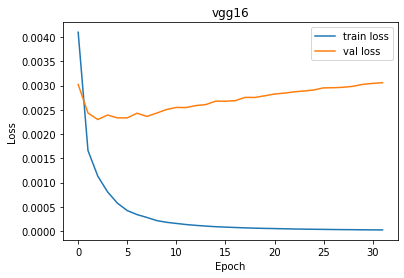

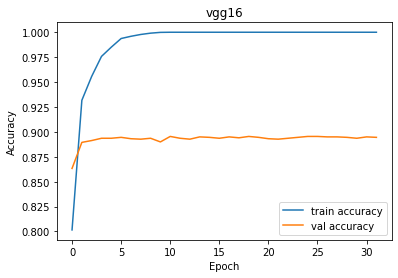

In [ ]:
# Plot and save logs of train and val loss-accuracy
if model_checkpoint_path_dict.get('vgg16', None) and RESUME_TRAIN:
  # plot train and val loss
  fig_path = Path(logs_destination) / \
      f"vgg16-epochs-{epochs_vgg16_all}-loss-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_loss(train_loss=train_loss_vgg16_all, 
            val_loss=val_loss_vgg16_all, 
            train_label='train loss', 
            val_label='val loss',
            title="vgg16",
            xlabel="Epoch",
            ylabel="Loss",
            save=True,
            save_path=fig_path)

  # plot train and val accuracy
  fig_path = Path(logs_destination) / \
      f"vgg16-epochs-{epochs_vgg16_all}-accuracy-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_accuracy(train_acuracy=train_accuracy_vgg16_all, 
                val_acuracy=val_accuracy_vgg16_all, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="vgg16",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=True,
                save_path=fig_path)

In [ ]:
# Save Latest Training Checkpoint Again 
if model_checkpoint_path_dict.get('vgg16', None) and RESUME_TRAIN:
  # save model checkpoint again
  checkpoint_file_name_vgg16= \
                  f"vgg16-epochs-{epochs_vgg16_all}-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}"
  train_history_vgg16_all = \
                  prepare_history_dict(loss=train_loss_vgg16_all, 
                                      accuracy=train_accuracy_vgg16_all)
  validation_history_vgg16_all = \
                  prepare_history_dict(loss=val_loss_vgg16_all, 
                                      accuracy=val_accuracy_vgg16_all)
  
  model_path_vgg16 = save_model_checkpoint(
                        model_name='vgg16', 
                        model=model_vgg16, 
                        criterion=criterion_vgg16, 
                        optimizer=optimizer_vgg16, 
                        epochs=epochs_vgg16_all, 
                        batch_size=batch_size,
                        train_history=train_history_vgg16_all,
                        validation_history=validation_history_vgg16_all,
                        file_name=checkpoint_file_name_vgg16,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_vgg16:
    saved_model_list['vgg16'] = model_path_vgg16
  else:
    raise Exception("Error: Model did not saved succesfully!")

Model checkpoint saved at 'models/vgg16-epochs-32-11_04_2021_08_12_01.pth'


### ResNet

In [ ]:
# Load Saved Model Checkpoint
if model_checkpoint_path_dict.get('resnet18', None) is not None:
  # pretrained resnet18 model
  model_resnet18 = models.resnet18(pretrained=True)

  # Freeze weights
  for param in model_resnet18.parameters():
    param.requires_grad = False
  
  # see the number of features
  n_features_resnet18 = model_resnet18.fc.in_features
  print(n_features_resnet18)

  # We're doing K-class classification
  model_resnet18.fc = nn.Linear(n_features_resnet18, K)

  # Use GPU if available
  print(device)
  model_resnet18.to(device)

  # Loss and optimizer
  criterion_resnet18 = nn.CrossEntropyLoss()
  optimizer_resnet18 = torch.optim.Adam(model_resnet18.parameters())

  # load the model checkpoint
  checkpoint_resnet18 = load_model_checkpoint(
                      model_checkpoint_path_dict.get('resnet18'))

  # load model weights state_dict
  model_resnet18.load_state_dict(checkpoint_resnet18['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')

  # load trained optimizer state_dict
  optimizer_resnet18.load_state_dict(checkpoint_resnet18['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')

  # Previous epochs
  epochs_resnet18_pre = checkpoint_resnet18['epoch']
  print(f"Previously trained for {epochs_resnet18_pre} number of epochs...")

  # load the criterion
  criterion_resnet18 = checkpoint_resnet18['loss']
  print('Trained model loss function loaded...')

  train_loss_resnet18_pre, train_accuracy_resnet18_pre = retrieve_history_list(
                                checkpoint_resnet18['train_history'])
  val_loss_resnet18_pre, val_accuracy_resnet18_pre = retrieve_history_list(
                                checkpoint_resnet18['validation_history'])

512
cuda:0
Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Previously trained for 31 number of epochs...
Trained model loss function loaded...


In [ ]:
# Resume Training
if model_checkpoint_path_dict.get('resnet18', None) and RESUME_TRAIN:
  # train for more epochs
  epochs_resnet18_new = new_epochs
  print(f"Train for {epochs_resnet18_new} more epochs...")

  # resume train
  train_loss_resnet18_new, train_accuracy_resnet18_new, val_loss_resnet18_new, \
  val_accuracy_resnet18_new = train_and_validate(
        model=model_resnet18, 
        criterion=criterion_resnet18, 
        optimizer=optimizer_resnet18, 
        train_loader=train_loader, 
        test_loader=test_loader, 
        device=device, 
        epochs=epochs_resnet18_new)
  
  # togather all things
  train_loss_resnet18_all = train_loss_resnet18_pre + train_loss_resnet18_new
  train_accuracy_resnet18_all = train_accuracy_resnet18_pre \
                              + train_accuracy_resnet18_new
  val_loss_resnet18_all = val_loss_resnet18_pre + val_loss_resnet18_new
  val_accuracy_resnet18_all = val_accuracy_resnet18_pre + val_accuracy_resnet18_new
  epochs_resnet18_all = epochs_resnet18_pre + epochs_resnet18_new

Train for 1 more epochs...
Epoch 1 of 1
Train Loss: 0.003061, Train Acc: 0.849672
Val Loss: 0.003579, Val Acc: 0.834862
Duration: 0:00:57.300393


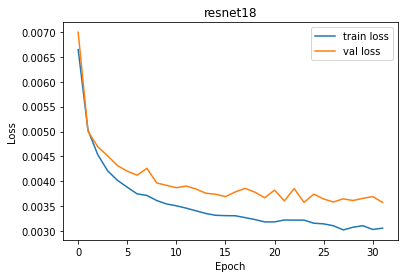

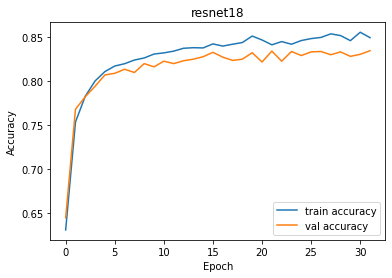

In [ ]:
# Plot and save logs of train and val loss-accuracy
if model_checkpoint_path_dict.get('resnet18', None) and RESUME_TRAIN:
  # plot train and val loss
  fig_path = Path(logs_destination) / \
      f"resnet18-epochs-{epochs_resnet18_all}-loss-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_loss(train_loss=train_loss_resnet18_all, 
            val_loss=val_loss_resnet18_all, 
            train_label='train loss', 
            val_label='val loss',
            title="resnet18",
            xlabel="Epoch",
            ylabel="Loss",
            save=True,
            save_path=fig_path)

  # plot train and val accuracy
  fig_path = Path(logs_destination) / \
      f"resnet18-epochs-{epochs_resnet18_all}-accuracy-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_accuracy(train_acuracy=train_accuracy_resnet18_all, 
                val_acuracy=val_accuracy_resnet18_all, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="resnet18",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=True,
                save_path=fig_path)

In [ ]:
# Save Latest Training Checkpoint Again 
if model_checkpoint_path_dict.get('resnet18', None) and RESUME_TRAIN:
  # save model checkpoint again
  checkpoint_file_name_resnet18= \
                  f"resnet18-epochs-{epochs_resnet18_all}-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}"
  train_history_resnet18_all = \
                  prepare_history_dict(loss=train_loss_resnet18_all, 
                                      accuracy=train_accuracy_resnet18_all)
  validation_history_resnet18_all = \
                  prepare_history_dict(loss=val_loss_resnet18_all, 
                                      accuracy=val_accuracy_resnet18_all)
  
  model_path_resnet18 = save_model_checkpoint(
                        model_name='resnet18', 
                        model=model_resnet18, 
                        criterion=criterion_resnet18, 
                        optimizer=optimizer_resnet18, 
                        epochs=epochs_resnet18_all, 
                        batch_size=batch_size,
                        train_history=train_history_resnet18_all,
                        validation_history=validation_history_resnet18_all,
                        file_name=checkpoint_file_name_resnet18,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_resnet18:
    saved_model_list['resnet18'] = model_path_resnet18
  else:
    raise Exception("Error: Model did not saved succesfully!")

Model checkpoint saved at 'models/resnet18-epochs-32-11_04_2021_08_12_59.pth'


### DenseNet

In [ ]:
# Load Saved Model Checkpoint
if model_checkpoint_path_dict.get('densenet161', None) is not None:
  # pretrained densenet161 model
  model_densenet161 = models.densenet161(pretrained=True)

  # Freeze weights
  for param in model_densenet161.parameters():
    param.requires_grad = False
  
  # see the number of features
  n_features_densenet161 = model_densenet161.classifier.in_features
  print(n_features_densenet161)

  # We're doing K-class classification
  model_densenet161.classifier = nn.Linear(n_features_densenet161, K)

  # Use GPU if available
  print(device)
  model_densenet161.to(device)

  # Loss and optimizer
  criterion_densenet161 = nn.CrossEntropyLoss()
  optimizer_densenet161 = torch.optim.Adam(model_densenet161.parameters())

  # load the model checkpoint
  checkpoint_densenet161 = load_model_checkpoint(
                      model_checkpoint_path_dict.get('densenet161'))

  # load model weights state_dict
  model_densenet161.load_state_dict(checkpoint_densenet161['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')

  # load trained optimizer state_dict
  optimizer_densenet161.load_state_dict(checkpoint_densenet161['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')

  # Previous epochs
  epochs_densenet161_pre = checkpoint_densenet161['epoch']
  print(f"Previously trained for {epochs_densenet161_pre} number of epochs...")

  # load the criterion
  criterion_densenet161 = checkpoint_densenet161['loss']
  print('Trained model loss function loaded...')

  train_loss_densenet161_pre, train_accuracy_densenet161_pre = retrieve_history_list(
                                checkpoint_densenet161['train_history'])
  val_loss_densenet161_pre, val_accuracy_densenet161_pre = retrieve_history_list(
                                checkpoint_densenet161['validation_history'])

2208
cuda:0
Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Previously trained for 31 number of epochs...
Trained model loss function loaded...


In [ ]:
# Resume Training
if model_checkpoint_path_dict.get('densenet161', None) and RESUME_TRAIN:
  # train for more epochs
  epochs_densenet161_new = new_epochs
  print(f"Train for {epochs_densenet161_new} more epochs...")

  # resume train
  train_loss_densenet161_new, train_accuracy_densenet161_new, val_loss_densenet161_new, \
  val_accuracy_densenet161_new = train_and_validate(
        model=model_densenet161, 
        criterion=criterion_densenet161, 
        optimizer=optimizer_densenet161, 
        train_loader=train_loader, 
        test_loader=test_loader, 
        device=device, 
        epochs=epochs_densenet161_new)
  
  # togather all things
  train_loss_densenet161_all = train_loss_densenet161_pre + train_loss_densenet161_new
  train_accuracy_densenet161_all = train_accuracy_densenet161_pre \
                              + train_accuracy_densenet161_new
  val_loss_densenet161_all = val_loss_densenet161_pre + val_loss_densenet161_new
  val_accuracy_densenet161_all = val_accuracy_densenet161_pre + val_accuracy_densenet161_new
  epochs_densenet161_all = epochs_densenet161_pre + epochs_densenet161_new

Train for 1 more epochs...
Epoch 1 of 1
Train Loss: 0.001955, Train Acc: 0.909436
Val Loss: 0.003131, Val Acc: 0.860550
Duration: 0:03:21.531214


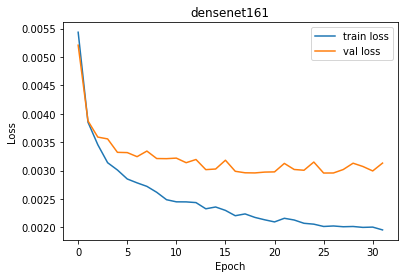

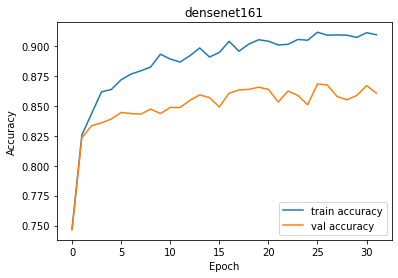

In [ ]:
# Plot and save logs of train and val loss-accuracy
if model_checkpoint_path_dict.get('densenet161', None) and RESUME_TRAIN:
  # plot train and val loss
  fig_path = Path(logs_destination) / \
      f"densenet161-epochs-{epochs_densenet161_all}-loss-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_loss(train_loss=train_loss_densenet161_all, 
            val_loss=val_loss_densenet161_all, 
            train_label='train loss', 
            val_label='val loss',
            title="densenet161",
            xlabel="Epoch",
            ylabel="Loss",
            save=True,
            save_path=fig_path)

  # plot train and val accuracy
  fig_path = Path(logs_destination) / \
      f"densenet161-epochs-{epochs_densenet161_all}-accuracy-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_accuracy(train_acuracy=train_accuracy_densenet161_all, 
                val_acuracy=val_accuracy_densenet161_all, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="densenet161",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=True,
                save_path=fig_path)

In [ ]:
# Save Latest Training Checkpoint Again 
if model_checkpoint_path_dict.get('densenet161', None) and RESUME_TRAIN:
  # save model checkpoint again
  checkpoint_file_name_densenet161= \
                  f"densenet161-epochs-{epochs_densenet161_all}-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}"
  train_history_densenet161_all = \
                  prepare_history_dict(loss=train_loss_densenet161_all, 
                                      accuracy=train_accuracy_densenet161_all)
  validation_history_densenet161_all = \
                  prepare_history_dict(loss=val_loss_densenet161_all, 
                                      accuracy=val_accuracy_densenet161_all)
  
  model_path_densenet161 = save_model_checkpoint(
                        model_name='densenet161', 
                        model=model_densenet161, 
                        criterion=criterion_densenet161, 
                        optimizer=optimizer_densenet161, 
                        epochs=epochs_densenet161_all, 
                        batch_size=batch_size,
                        train_history=train_history_densenet161_all,
                        validation_history=validation_history_densenet161_all,
                        file_name=checkpoint_file_name_densenet161,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_densenet161:
    saved_model_list['densenet161'] = model_path_densenet161
  else:
    raise Exception("Error: Model did not saved succesfully!")

Model checkpoint saved at 'models/densenet161-epochs-32-11_04_2021_08_16_23.pth'


### AlexNet

In [ ]:
# Load Saved Model Checkpoint
if model_checkpoint_path_dict.get('alexnet', None) is not None:
  # pretrained alexnet model
  model_alexnet = models.alexnet(pretrained=True)

  # Freeze weights
  for param in model_alexnet.parameters():
    param.requires_grad = False
  
  # see the number of features
  n_features_alexnet = model_alexnet.classifier[1].in_features
  print(n_features_alexnet)

  # We're doing K-class classification
  model_alexnet.classifier = nn.Linear(n_features_alexnet, K)

  # Use GPU if available
  print(device)
  model_alexnet.to(device)

  # Loss and optimizer
  criterion_alexnet = nn.CrossEntropyLoss()
  optimizer_alexnet = torch.optim.Adam(model_alexnet.parameters())

  # load the model checkpoint
  checkpoint_alexnet = load_model_checkpoint(
                      model_checkpoint_path_dict.get('alexnet'))

  # load model weights state_dict
  model_alexnet.load_state_dict(checkpoint_alexnet['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')

  # load trained optimizer state_dict
  optimizer_alexnet.load_state_dict(checkpoint_alexnet['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')

  # Previous epochs
  epochs_alexnet_pre = checkpoint_alexnet['epoch']
  print(f"Previously trained for {epochs_alexnet_pre} number of epochs...")

  # load the criterion
  criterion_alexnet = checkpoint_alexnet['loss']
  print('Trained model loss function loaded...')

  train_loss_alexnet_pre, train_accuracy_alexnet_pre = retrieve_history_list(
                                checkpoint_alexnet['train_history'])
  val_loss_alexnet_pre, val_accuracy_alexnet_pre = retrieve_history_list(
                                checkpoint_alexnet['validation_history'])

9216
cuda:0
Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Previously trained for 31 number of epochs...
Trained model loss function loaded...


In [ ]:
# Resume Training
if model_checkpoint_path_dict.get('alexnet', None) and RESUME_TRAIN:
  # train for more epochs
  epochs_alexnet_new = new_epochs
  print(f"Train for {epochs_alexnet_new} more epochs...")

  # resume train
  train_loss_alexnet_new, train_accuracy_alexnet_new, val_loss_alexnet_new, \
  val_accuracy_alexnet_new = train_and_validate(
        model=model_alexnet, 
        criterion=criterion_alexnet, 
        optimizer=optimizer_alexnet, 
        train_loader=train_loader, 
        test_loader=test_loader, 
        device=device, 
        epochs=epochs_alexnet_new)
  
  # togather all things
  train_loss_alexnet_all = train_loss_alexnet_pre + train_loss_alexnet_new
  train_accuracy_alexnet_all = train_accuracy_alexnet_pre \
                              + train_accuracy_alexnet_new
  val_loss_alexnet_all = val_loss_alexnet_pre + val_loss_alexnet_new
  val_accuracy_alexnet_all = val_accuracy_alexnet_pre + val_accuracy_alexnet_new
  epochs_alexnet_all = epochs_alexnet_pre + epochs_alexnet_new

Train for 1 more epochs...
Epoch 1 of 1
Train Loss: 0.000305, Train Acc: 0.996723
Val Loss: 0.002708, Val Acc: 0.896789
Duration: 0:00:46.992363


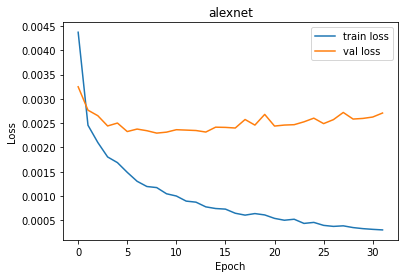

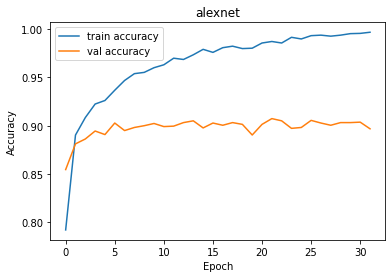

In [ ]:
# Plot and save logs of train and val loss-accuracy
if model_checkpoint_path_dict.get('alexnet', None) and RESUME_TRAIN:
  # plot train and val loss
  fig_path = Path(logs_destination) / \
      f"alexnet-epochs-{epochs_alexnet_all}-loss-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_loss(train_loss=train_loss_alexnet_all, 
            val_loss=val_loss_alexnet_all, 
            train_label='train loss', 
            val_label='val loss',
            title="alexnet",
            xlabel="Epoch",
            ylabel="Loss",
            save=True,
            save_path=fig_path)

  # plot train and val accuracy
  fig_path = Path(logs_destination) / \
      f"alexnet-epochs-{epochs_alexnet_all}-accuracy-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_accuracy(train_acuracy=train_accuracy_alexnet_all, 
                val_acuracy=val_accuracy_alexnet_all, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="alexnet",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=True,
                save_path=fig_path)

In [ ]:
# Save Latest Training Checkpoint Again 
if model_checkpoint_path_dict.get('alexnet', None) and RESUME_TRAIN:
  # save model checkpoint again
  checkpoint_file_name_alexnet= \
                  f"alexnet-epochs-{epochs_alexnet_all}-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}"
  train_history_alexnet_all = \
                  prepare_history_dict(loss=train_loss_alexnet_all, 
                                      accuracy=train_accuracy_alexnet_all)
  validation_history_alexnet_all = \
                  prepare_history_dict(loss=val_loss_alexnet_all, 
                                      accuracy=val_accuracy_alexnet_all)
  
  model_path_alexnet = save_model_checkpoint(
                        model_name='alexnet', 
                        model=model_alexnet, 
                        criterion=criterion_alexnet, 
                        optimizer=optimizer_alexnet, 
                        epochs=epochs_alexnet_all, 
                        batch_size=batch_size,
                        train_history=train_history_alexnet_all,
                        validation_history=validation_history_alexnet_all,
                        file_name=checkpoint_file_name_alexnet,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_alexnet:
    saved_model_list['alexnet'] = model_path_alexnet
  else:
    raise Exception("Error: Model did not saved succesfully!")

Model checkpoint saved at 'models/alexnet-epochs-32-11_04_2021_08_17_12.pth'


## Save Logs

In [ ]:
if SAVE_LOGS_TO_GOOGLE_DRIVE and GOOGLE_DRIVE_LOGS_PATH:
  # see inside gdrive
  print(*os.listdir(GOOGLE_DRIVE_MOUNTED_DIRNAME), sep='\n')
  # select location of gdrive
  gdrive_logs_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_LOGS_PATH}'
  print(*os.listdir(gdrive_logs_path), sep='\n')

  # copy colab models to gdrive
  # how to : https://stackoverflow.com/q/59710439/8520849
  # !cp -av 'logs' 'gdrive/MyDrive/ML/concrete_crack_detection/logs'
  # os.system("cp -av {} {}".format(logs_destination, gdrive_logs_path))
  copytree(src=logs_destination, dst=gdrive_logs_path)

MyDrive
.file-revisions-by-id
.shortcut-targets-by-id
.Trash-0
resnet18-epochs-11-accuracy-11_03_2021_22_06_25.png
densenet161-epochs-3-loss-11_03_2021_20_59_52.png
vgg16-epochs-3-accuracy-11_03_2021_20_51_18.png
resnet18-epochs-3-accuracy-11_03_2021_20_53_12.png
vgg16-epochs-9-loss-11_03_2021_21_46_42.png
densenet161-epochs-7-loss-11_03_2021_21_35_59.png
resnet18-epochs-7-loss-11_03_2021_21_29_21.png
resnet18-epochs-9-accuracy-11_03_2021_21_48_34.png
resnet18-epochs-3-loss-11_03_2021_20_53_12.png
alexnet-epochs-9-accuracy-11_03_2021_21_56_46.png
densenet161-epochs-9-loss-11_03_2021_21_55_13.png
resnet18-epochs-7-accuracy-11_03_2021_21_29_21.png
densenet161-epochs-9-accuracy-11_03_2021_21_55_13.png
vgg16-epochs-9-accuracy-11_03_2021_21_46_42.png
vgg16-epochs-7-accuracy-11_03_2021_21_27_29.png
resnet18-epochs-9-loss-11_03_2021_21_48_34.png
resnet18-epochs-5-accuracy-11_03_2021_21_13_11.png
densenet161-epochs-3-accuracy-11_03_2021_20_59_53.png
vgg16-epochs-11-loss-11_03_2021_22_04_33.png

## Save Checkpoint to Google Drive

In [ ]:
if SAVE_MODELS_TO_GOOGLE_DRIVE and (RESUME_TRAINING_STAGE or\
                                   ACTIVE_INITIAL_TRAINING_STAGE):
  # see inside gdrive
  print(*os.listdir(GOOGLE_DRIVE_MOUNTED_DIRNAME), sep='\n')
  # select location of gdrive
  gdrive_models_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_MODELS_PATH}'
  print(*os.listdir(gdrive_models_path), sep='\n')

  # copy colab models to gdrive
  # how to : https://stackoverflow.com/q/59710439/8520849
  # !cp -av 'models' 'gdrive/MyDrive/ML/concrete_crack_detection/models'
  # os.system("cp -av {} {}".format(saved_model_destination, gdrive_models_path))
  copytree(src=saved_model_destination, dst=gdrive_models_path)

MyDrive
.file-revisions-by-id
.shortcut-targets-by-id
.Trash-0
vgg16-epochs-11-11_03_2021_22_04_33.pth
resnet18-epochs-11-11_03_2021_22_06_25.pth
densenet161-epochs-11-11_03_2021_22_13_04.pth
alexnet-epochs-11-11_03_2021_22_14_38.pth
alexnet-epochs-1-2021-11-03 20:42:25.876403.pth
densenet161-epochs-9-11_03_2021_21_55_13.pth
resnet18-epochs-5-11_03_2021_21_13_11.pth
densenet161-epochs-5-11_03_2021_21_19_51.pth
vgg16-epochs-1-2021-11-03 20:42:24.386347.pth
vgg16-epochs-9-11_03_2021_21_46_42.pth
densenet161-epochs-1-2021-11-03 20:42:24.916979.pth
alexnet-epochs-5-11_03_2021_21_21_24.pth
alexnet-epochs-7-11_03_2021_21_37_33.pth
vgg16-epochs-5-11_03_2021_21_11_19.pth
vgg16-epochs-7-11_03_2021_21_27_30.pth
vgg16-epochs-3-11_03_2021_20_51_18.pth
densenet161-epochs-7-11_03_2021_21_36_00.pth
alexnet-epochs-3-11_03_2021_21_01_28.pth
alexnet-epochs-9-11_03_2021_21_56_47.pth
resnet18-epochs-3-11_03_2021_20_53_12.pth
resnet18-epochs-1-2021-11-03 20:42:24.662719.pth
resnet18-epochs-7-11_03_2021_21_

# Conclusions

## Evaluation Method

In [ ]:
# evaluation function
def evaluate(model, criterion, optimizer, dataloader, device):
  model.eval()
  val_running_loss = 0.0
  val_running_correct = 0

  pred_list = np.empty(shape=0)
  target_list = np.empty(shape=0)

  with torch.no_grad():
    for inputs, targets in dataloader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Get prediction
      # torch.max returns both max and argmax
      _, predictions = torch.max(outputs, 1)

      val_running_loss += loss.item()
      val_running_correct += (predictions == targets).sum().item()

      # store predictions and targets for showing Evaluation Statistics
      pred_list = np.concatenate((pred_list, predictions.cpu().detach().numpy()), axis=0)
      target_list = np.concatenate((target_list, targets.cpu().detach().numpy()), axis=0)
    
    val_loss = val_running_loss/len(dataloader.dataset)
    val_accuracy = val_running_correct/len(dataloader.dataset)
    history = {
        'loss': val_loss,
        'accuracy': val_accuracy,
        'y_true': target_list,
        'y_pred': pred_list
    }
    return history

In [ ]:
def show_evaluation_history(y_true, y_pred, pos_label, y_labels, y_label_names, 
                            save=False, save_path_dir=None, file_name_prefix=None):
  # show classification report
  print("Classification Report:")
  cls_rep_str = classification_report(y_true=y_true, 
                                  y_pred=y_pred, 
                                  labels=y_labels, 
                                  target_names=y_label_names, 
                                  digits=4, 
                                  output_dict=False)
  print(cls_rep_str)
  cls_rep_dict = classification_report(y_true=y_true, 
                                  y_pred=y_pred, 
                                  labels=y_labels, 
                                  target_names=y_label_names, 
                                  digits=4, 
                                  output_dict=True)
  print(cls_rep_dict)
  # save classification_report as json file
  if save and save_path_dir:
    try:
      import json
      file_path = Path(save_path_dir) / \
              f"{file_name_prefix if file_name_prefix else \
              ''}-classification_report-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.json"
      with open(file_path, "w") as outfile:
        json.dump(cls_rep_dict, outfile)
    except Exception as e:
      print("Classification_report json file save failed!")
      raise e

  # show Precision Recall
  ps = precision_score(y_true=y_true, 
                       y_pred=y_pred, 
                       labels=y_labels, 
                       pos_label=pos_label, 
                       average='binary')
  print(f"precision score: {ps}")

  # show recall score
  rs = recall_score(y_true=y_true, 
                    y_pred=y_pred, 
                    labels=y_labels, 
                    pos_label=pos_label, 
                    average='binary')
  print(f"recall score: {rs}")

  # show f1 score
  f1s = f1_score(y_true=y_true, 
                  y_pred=y_pred, 
                  labels=y_labels, 
                  pos_label=pos_label, 
                  average='binary')
  print(f"F1 score: {f1s}")

  # show accuracy score
  acc_score = accuracy_score(y_true=y_true, 
                             y_pred=y_pred,
                             normalize=True)
  print(f"accuracy score: {acc_score}")

  # show confusion matrix
  print("Confusion matrix:")
  cm = confusion_matrix(y_true=y_true, 
                        y_pred=y_pred, 
                        labels=y_labels, 
                        normalize=None)
  cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_labels)
  cm_disp.plot(values_format='d')

  if save and save_path_dir:
    try:
      file_path = Path(save_path_dir) / \
              f"{file_name_prefix if file_name_prefix else \
              ''}-confusion_matrix-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
      plt.savefig(file_path)
    except Exception as e:
      print("Figure save failed!")
      raise e
  plt.show()

  # show Precision Recall Display
  precision, recall, _ = precision_recall_curve(y_true=y_true, 
                                                probas_pred=y_pred,
                                                pos_label=pos_label)
  print(f"precision_recall_curve: precision={precision} and recall={recall}")
  average_precision = average_precision_score(y_true=y_true, 
                                              y_score=y_pred,
                                              average='macro',
                                              pos_label=pos_label)
  prd_disp = PrecisionRecallDisplay(precision=precision, 
                                    recall=recall,
                                    average_precision=average_precision, 
                                    estimator_name=None)
  prd_disp.plot()
  if save and save_path_dir:
    try:
      file_path = Path(save_path_dir) / \
              f"{file_name_prefix if file_name_prefix else \
              ''}-precision_recall_display-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
      plt.savefig(file_path)
    except Exception as e:
      print("Figure save failed!")
      raise e
  plt.show()

### Important Considerations

- Our data set labels as `crack` and `noncrack`
- After loading dataset into dataloader we have seen labes are converted as numbers, also `crack` as `0` and `noncrack` as `1`. We confermed that by seeing number of crack and noncrack images into test dataset and later comparing with `targets` which was represented as *Tensor* with values `0` and `1` representing class labels.
- So in our case **positive label** `crack` represnting as `pos_label=0` for **binary classification**.




In [ ]:
# according to our binary classification problem and seeing dataloader targets reprentation
# positive class `crack` represnting as `pos_label=0`
# Store it a variable for later use. Otherwise, some function in binary classification `pos_label: default=1`
POS_LABEL = 0
# store corresponding string name
POS_LABEL_NAME = 'crack'

# Store all Class Label name in a variable for later use
# keep in mind store them as 0 indexed sequnce, so order is very important
Y_LABELS = [0, 1] # corresponding list of label indices
Y_LABEL_NAMES = ['crack', 'noncrack'] # 0 index for `crack` and 1 index for `noncrack`


### VGG

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('vgg16', None):
  # evaluate model
  vgg16_history = evaluate(
        model=model_vgg16, 
        criterion=criterion_vgg16, 
        optimizer=optimizer_vgg16,
        dataloader=test_loader, 
        device=device)

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('vgg16', None):  
  show_evaluation_history(y_true=vgg16_history['y_true'], 
                          y_pred=vgg16_history['y_pred'], 
                          pos_label=POS_LABEL,
                          y_labels=Y_LABELS, 
                          y_label_names=Y_LABEL_NAMES, 
                          save=True, 
                          save_path_dir=LOGS_DIRNAME, 
                          file_name_prefix='vgg16-')


### ResNet

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('resnet18', None):
  # evaluate model
  resnet18_history = evaluate(
        model=model_resnet18, 
        criterion=criterion_resnet18, 
        optimizer=optimizer_resnet18,
        dataloader=test_loader, 
        device=device)

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('resnet18', None):  
  show_evaluation_history(y_true=resnet18_history['y_true'], 
                          y_pred=resnet18_history['y_pred'], 
                          pos_label=POS_LABEL,
                          y_labels=Y_LABELS, 
                          y_label_names=Y_LABEL_NAMES, 
                          save=True, 
                          save_path_dir=LOGS_DIRNAME, 
                          file_name_prefix='resnet18-')


### DenseNet

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('densenet161', None):
  # evaluate model
  densenet161_history = evaluate(
        model=model_densenet161, 
        criterion=criterion_densenet161, 
        optimizer=optimizer_densenet161,
        dataloader=test_loader, 
        device=device)

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('densenet161', None):  
  show_evaluation_history(y_true=densenet161_history['y_true'], 
                          y_pred=densenet161_history['y_pred'], 
                          pos_label=POS_LABEL,
                          y_labels=Y_LABELS, 
                          y_label_names=Y_LABEL_NAMES, 
                          save=True, 
                          save_path_dir=LOGS_DIRNAME, 
                          file_name_prefix='densenet161-')


### AlexNet

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('alexnet', None):
  # evaluate model
  alexnet_history = evaluate(
        model=model_alexnet, 
        criterion=criterion_alexnet, 
        optimizer=optimizer_alexnet,
        dataloader=test_loader, 
        device=device)

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('alexnet', None):  
  show_evaluation_history(y_true=alexnet_history['y_true'], 
                          y_pred=alexnet_history['y_pred'], 
                          pos_label=POS_LABEL,
                          y_labels=Y_LABELS, 
                          y_label_names=Y_LABEL_NAMES, 
                          save=True, 
                          save_path_dir=LOGS_DIRNAME, 
                          file_name_prefix='alexnet-')


## Generate All History to CSV

In [ ]:
if ACTIVE_EVALUATION_STAGE:
  # store all history to file
  # import pandas as pd
  # dictionary of lists  
  model_eval_hist_dict = {}
  model_train_hist_dict = {}
  
  if model_checkpoint_path_dict.get('vgg16', None):
    model_eval_hist_dict['vgg16_y_true'] = vgg16_history['y_true']
    model_eval_hist_dict['vgg16_y_pred'] = vgg16_history['y_pred']

    model_train_hist_dict['vgg16_train_loss'] = train_loss_vgg16_pre
    model_train_hist_dict['vgg16_test_loss'] = val_loss_vgg16_pre
    model_train_hist_dict['vgg16_train_acc'] = train_accuracy_vgg16_pre
    model_train_hist_dict['vgg16_test_acc'] = val_accuracy_vgg16_pre
  
  if model_checkpoint_path_dict.get('resnet18', None):
    model_eval_hist_dict['resnet18_y_true'] = resnet18_history['y_true']
    model_eval_hist_dict['resnet18_y_pred'] = resnet18_history['y_pred']

    model_train_hist_dict['resnet18_train_loss'] = train_loss_resnet18_pre
    model_train_hist_dict['resnet18_test_loss'] = val_loss_resnet18_pre
    model_train_hist_dict['resnet18_train_acc'] = train_accuracy_resnet18_pre
    model_train_hist_dict['resnet18_test_acc'] = val_accuracy_resnet18_pre
  
  if model_checkpoint_path_dict.get('densenet161', None):
    model_eval_hist_dict['densenet161_y_true'] = densenet161_history['y_true']
    model_eval_hist_dict['densenet161_y_pred'] = densenet161_history['y_pred']

    model_train_hist_dict['densenet161_train_loss'] = train_loss_densenet161_pre
    model_train_hist_dict['densenet161_test_loss'] = val_loss_densenet161_pre
    model_train_hist_dict['densenet161_train_acc'] = train_accuracy_densenet161_pre
    model_train_hist_dict['densenet161_test_acc'] = val_accuracy_densenet161_pre

  if model_checkpoint_path_dict.get('alexnet', None):
    model_eval_hist_dict['alexnet_y_true'] = alexnet_history['y_true']
    model_eval_hist_dict['alexnet_y_pred'] = alexnet_history['y_pred']

    model_train_hist_dict['alexnet_train_loss'] = train_loss_alexnet_pre
    model_train_hist_dict['alexnet_test_loss'] = val_loss_alexnet_pre
    model_train_hist_dict['alexnet_train_acc'] = train_accuracy_alexnet_pre
    model_train_hist_dict['alexnet_test_acc'] = val_accuracy_alexnet_pre
  

  df_model_eval_hist_dict = pd.DataFrame(model_eval_hist_dict) 
  df_model_train_hist_dict = pd.DataFrame(model_train_hist_dict)

  model_eval_hist_dict_path = Path(LOGS_DIRNAME) / f"model_eval_hist-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.csv"
  model_train_hist_dict_path = Path(LOGS_DIRNAME) / f"model_train_hist-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.csv"
  # saving the dataframe
  df_model_eval_hist_dict.to_csv(model_eval_hist_dict_path)
  df_model_train_hist_dict.to_csv(model_train_hist_dict_path)

  print("Saved history at:", model_eval_hist_dict_path, model_train_hist_dict_path)


## Save Logs

In [ ]:
if SAVE_LOGS_TO_GOOGLE_DRIVE and GOOGLE_DRIVE_LOGS_PATH:
  # see inside gdrive
  print(*os.listdir(GOOGLE_DRIVE_MOUNTED_DIRNAME), sep='\n')
  # select location of gdrive
  gdrive_logs_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_LOGS_PATH}'
  print(*os.listdir(gdrive_logs_path), sep='\n')

  # copy colab models to gdrive
  # how to : https://stackoverflow.com/q/59710439/8520849
  # !cp -av 'logs' 'gdrive/MyDrive/ML/concrete_crack_detection/logs'
  # os.system("cp -av {} {}".format(logs_destination, gdrive_logs_path))
  copytree(src=logs_destination, dst=gdrive_logs_path)

MyDrive
.file-revisions-by-id
.shortcut-targets-by-id
.Trash-0
resnet18-epochs-11-accuracy-11_03_2021_22_06_25.png
densenet161-epochs-3-loss-11_03_2021_20_59_52.png
vgg16-epochs-3-accuracy-11_03_2021_20_51_18.png
resnet18-epochs-3-accuracy-11_03_2021_20_53_12.png
vgg16-epochs-9-loss-11_03_2021_21_46_42.png
densenet161-epochs-7-loss-11_03_2021_21_35_59.png
resnet18-epochs-7-loss-11_03_2021_21_29_21.png
resnet18-epochs-9-accuracy-11_03_2021_21_48_34.png
resnet18-epochs-3-loss-11_03_2021_20_53_12.png
alexnet-epochs-9-accuracy-11_03_2021_21_56_46.png
densenet161-epochs-9-loss-11_03_2021_21_55_13.png
resnet18-epochs-7-accuracy-11_03_2021_21_29_21.png
densenet161-epochs-9-accuracy-11_03_2021_21_55_13.png
vgg16-epochs-9-accuracy-11_03_2021_21_46_42.png
vgg16-epochs-7-accuracy-11_03_2021_21_27_29.png
resnet18-epochs-9-loss-11_03_2021_21_48_34.png
resnet18-epochs-5-accuracy-11_03_2021_21_13_11.png
densenet161-epochs-3-accuracy-11_03_2021_20_59_53.png
vgg16-epochs-11-loss-11_03_2021_22_04_33.png

## Models used for Transfer Learning

We applied transfer learning technique based on the following models:
*   [VGG](https://arxiv.org/abs/1409.1556)
*   [ResNet](https://arxiv.org/abs/1512.03385)
*   [DenseNet](https://arxiv.org/abs/1608.06993)
*   [AlexNet](https://arxiv.org/abs/1404.5997)

### VGG16 Summary

In [ ]:
GENERATE_SUMMARY = True
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
if GENERATE_SUMMARY:
  # pretrained vgg16 model
  model_vgg16 = models.vgg16(pretrained=True)

  # Freeze weights
  for param in model_vgg16.parameters():
    param.requires_grad = False

  # see model detail
  print("Pretrained Model")
  print(model_vgg16)

  # Model summary
  # summary(model_vgg16, (3, 224, 224))

  # We want to replace the 'classifier'
  # print(model_vgg16.classifier)

  # see the number of features
  n_features_vgg16 = model_vgg16.classifier[0].in_features
  # print(n_features_vgg16)

  # We're doing K-class classification
  model_vgg16.classifier = nn.Linear(n_features_vgg16, K)

  # Let's see what the model is now
  print("Customized Model")
  print(model_vgg16)

  # Use GPU if available
  print(device)
  model_vgg16.to(device)

  # Loss and optimizer
  criterion_vgg16 = nn.CrossEntropyLoss()
  optimizer_vgg16 = torch.optim.Adam(model_vgg16.parameters())

  # Model summary
  # summary(model_vgg16, (3, 224, 224))

Pretrained Model
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padd

### ResNet

Prepare ResNet model for transfer learning.

In [ ]:
if GENERATE_SUMMARY:
  # pretrained resnet18 model
  model_resnet18 = models.resnet18(pretrained=True)

  # Freeze weights
  for param in model_resnet18.parameters():
    param.requires_grad = False

  # see model detail
  print("Pretrained Model")
  print(model_resnet18)

  # Model summary
  # summary(model_resnet18, (3, 224, 224))

  # We want to replace the 'fc'
  # print(model_resnet18.fc)

  # see the number of features
  n_features_resnet18 = model_resnet18.fc.in_features
  # print(n_features_resnet18)

  # We're doing K-class classification
  model_resnet18.fc = nn.Linear(n_features_resnet18, K)

  # Let's see what the model is now
  print("Customized Model")
  print(model_resnet18)

  # Use GPU if available
  print(device)
  model_resnet18.to(device)

  # Loss and optimizer
  criterion_resnet18 = nn.CrossEntropyLoss()
  optimizer_resnet18 = torch.optim.Adam(model_resnet18.parameters())

  # Model summary
  # summary(model_resnet18, (3, 224, 224))

Pretrained Model
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU

### DenseNet

Prepare DenseNet model for transfer learning.

In [ ]:
if GENERATE_SUMMARY:
  # pretrained densenet161 model
  model_densenet161 = models.densenet161(pretrained=True)

  # Freeze weights
  for param in model_densenet161.parameters():
    param.requires_grad = False

  # see model detail
  print("Pretrained Model")
  print(model_densenet161)

  # Model summary
  # summary(model_densenet161, (3, 224, 224))

  # We want to replace the 'classifier'
  # print(model_densenet161.classifier)

  # see the number of features
  n_features_densenet161 = model_densenet161.classifier.in_features
  # print(n_features_densenet161)

  # We're doing K-class classification
  model_densenet161.classifier = nn.Linear(n_features_densenet161, K)

  # Let's see what the model is now
  print("Customized Model")
  # print(model_densenet161)

  # Use GPU if available
  print(device)
  model_densenet161.to(device)

  # Loss and optimizer
  criterion_densenet161 = nn.CrossEntropyLoss()
  optimizer_densenet161 = torch.optim.Adam(model_densenet161.parameters())

  # Model summary
  # summary(model_densenet161, (3, 224, 224))

Pretrained Model
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

### AlexNet

Prepare AlexNet model for transfer learning.

In [ ]:
if GENERATE_SUMMARY:
  # pretrained alexnet model
  model_alexnet = models.alexnet(pretrained=True)

  # Freeze weights
  for param in model_alexnet.parameters():
    param.requires_grad = False

  # see model detail
  print("Pretrained Model")
  print(model_alexnet)
  
  # Model summary
  # summary(model_alexnet, (3, 224, 224))

  # We want to replace the 'classifier'
  print(model_alexnet.classifier)

  # see the number of features
  n_features_alexnet = model_alexnet.classifier[1].in_features
  print(n_features_alexnet)

  # We're doing K-class classification
  model_alexnet.classifier = nn.Linear(n_features_alexnet, K)

  # Let's see what the model is now
  print("Customized Model")
  print(model_alexnet)

  # Use GPU if available
  print(device)
  model_alexnet.to(device)

  # Loss and optimizer
  criterion_alexnet = nn.CrossEntropyLoss()
  optimizer_alexnet = torch.optim.Adam(model_alexnet.parameters())

  # Model summary
  # summary(model_alexnet, (3, 224, 224))

Pretrained Model
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4